# KOHONEN 2

2.2. KOH2: Sieć Kohonena na siatce sześciokątnej (1 tydzień, bez punktów, sprawozdanie po tym tygodniu)
Do implementacji z zeszłego tygodnia dodać możliwość ułożenia neuronów w topologii siatki sześciokątnej.

Zastosować oba warianty topologii i obie funkcje sąsiedztwa do wektorów danych ze zbiorów

MNIST  
https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones
(sieć Kohonena uruchomić na zbiorach bez etykiet!).

Przeanalizować otrzymane mapowanie danych uwzględniając etykiety danych. Jak dobrze znalezione klastry odpowiadają podziałowi na klasy?

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
from scipy.spatial import distance
import math
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import homogeneity_score, completeness_score, adjusted_rand_score, mutual_info_score, v_measure_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

In [7]:
class Kohonen:
    def __init__(self, N, M, dataset, width, gridtype = 'rectangle'):
        self.M=M
        self.N=N
        self.neurons = np.random.uniform(np.min(dataset), np.max(dataset), size=(N*M,dataset.shape[1]))
        self.width = width
        self.dataset = dataset
        if gridtype != 'rectangle':
            self.dist = self.dist_hex
        else:
            self.dist = self.dist_rec

    def learn(self, lambda_, method = 'gauss'):
        if method == 'mexican':
            neigh_fun = self.mexican_hat
        else:
            neigh_fun = self.gauss

        for iteration in range(lambda_):
            p = np.random.permutation(len(self.dataset))
            x = self.dataset[p]

            for input in x:
                bmu_idx = np.argmin(np.linalg.norm(self.neurons - input, axis=1)) #Best Matching Unit
                for i, neuron in enumerate(self.neurons):
               # calculate the distance between the neuron and the BMU
                    dist = self.dist(bmu_idx, i)

                    # calculate the learning rate for the neuron
                    lr = neigh_fun(dist, iteration) * self.alpha_fun(iteration, lambda_)

                    # update the weights of the neuron
                    self.neurons[i] += lr * (input - neuron)

    def classify(self):
        return [np.argmin([np.linalg.norm(neuron-input) for neuron in self.neurons]) for input in self.dataset]
    
    def limit_neurons(self, n):
        while (len(self.neurons) > n):
            distance = np.array([[np.linalg.norm(i-j) for id1, i in enumerate(self.neurons) if id1 != id2] for id2, j in enumerate(self.neurons)])
            distance = distance.reshape(len(self.neurons),len(self.neurons)-1)
            index = np.unravel_index(distance.argmin(), distance.shape)[0]
            self.neurons = np.delete(self.neurons,index,0)


    @staticmethod
    def gauss(x,t):
        return math.exp(-1 * x**2 * t**2)        
    
    @staticmethod
    def mexican_hat(x, t):
        value = (1-x**2) * math.exp(-1 * x**2 * t**2 / 2)
        return value

    def dist_rec(self, x, y):
        a = x%self.N-y%self.N #it is the horizontal distance between the two neurons.
        b = math.floor(x/self.N)-math.floor(y/self.N) #vertical distance between the neurons.
        
        return self.width*math.sqrt(a**2 + b**2) #pythagorean with width as the neighbourhood width
    
    def dist_hex(self, x, y):
        a = x%self.N-y%self.N #again, horizontal distance
        if (math.floor(x/self.N) - math.floor(y/self.N)) % 2 == 0: # means they are shifted by 1/2 of the grid's unit length
            a += 1/2
        b = (math.floor(x/self.N) - math.floor(y/self.N)) #this is the difference of row numbers - used to calculate vertical distance
        b *= (math.sqrt(3) / 2)
        return self.width*math.sqrt(a**2 + b**2)

    def alpha_fun(self, iteration, lambda_):
        return math.exp(-iteration/lambda_)
    
    def test(self, X_test):
        tmp = [np.argmin([np.linalg.norm(neuron-input) for neuron in self.neurons]) for input in X_test]
        return np.array(tmp).flatten()

### funkcje pomocnicze

In [8]:
def compare_models(train, test, labels, model_shapes, neurons, method = 'gauss', iterations = 100, width = 1, gridtype = 'rectangle'):
    if isinstance(model_shapes, tuple):
        model_shapes = [model_shapes]
    scores = []
    score_fun_ext = {
                'homogeneity' : homogeneity_score,
                'completeness' : completeness_score,
                'v - measure' : v_measure_score,
                'adjusted rand score' : adjusted_rand_score,
                'mutual info score' : mutual_info_score
            }
    score_fun_int = {
        'davies - bouldin' : davies_bouldin_score,
        'calinski - harabasz' : calinski_harabasz_score
    }
    models = [Kohonen(shape[0], shape[1], train, width, gridtype) for shape in model_shapes]
    for model in models:    
        model.learn(lambda_=iterations, method=method)
        model.limit_neurons(neurons)
        c = model.test(test)
        values = {}
        for name, fun in score_fun_ext.items():
            eval = fun(labels, c)
            values[name] = eval
        
        for name, fun in score_fun_int.items():
            eval = fun(test, c)
            values[name] = eval
        scores.append(values)
    df = pd.DataFrame(scores)
    df.index = model_shapes
    return df, models


def plot_scores(df):
    plt.figure(figsize=(24,12))
    for i, fun in enumerate(df.columns):
        plt.subplot(2,4,i+1)
        plt.bar(np.linspace(0, 1, len(df.index)),df[fun], width = 0.8/len(df.index), color = plt.get_cmap('Set3').colors)
        plt.xticks(np.linspace(0, 1, len(df.index)), df.index)
        plt.title(fun, fontsize = 'large')

from sklearn.decomposition import PCA
def plot_pca(models, X, labels):
    pca = PCA(2)
    tmp = pca.fit_transform(X)
    plt.figure(figsize = (6*len(models)+6,8))
    plt.subplot(1,len(models)+1,1)
    plt.title('true')
    plt.scatter(tmp[:,0], tmp[:,1], c = labels, s = 3) 
    for i, model in enumerate(models):
        c = model.test(X)
        nodes = pca.transform(model.neurons)
        plt.subplot(1,len(models)+1,i+2)
        plt.title(f'predicted with model of dimensions {model.N} x {model.M}')
        plt.scatter(tmp[:,0], tmp[:,1], c = c, s = 3)
        plt.scatter(nodes[:,0], nodes[:,1], c='black', s = 20)
        print(f"{model.N} x {model.M}")
    plt.show()


# dataset UCI HAR

In [112]:
X_train = np.asarray(pd.read_csv('../dane_kohonen/UCI HAR Dataset/train/X_train.txt', skipinitialspace=True, sep=' ', header = None))
y_train = np.asarray(pd.read_csv('../dane_kohonen/UCI HAR Dataset/train/y_train.txt', skipinitialspace=True, sep=' ', header = None))
X_test = np.asarray(pd.read_csv('../dane_kohonen/UCI HAR Dataset/test/X_test.txt', skipinitialspace=True, sep=' ', header = None))
y_test = np.asarray(pd.read_csv('../dane_kohonen/UCI HAR Dataset/test/y_test.txt', skipinitialspace=True, sep=' ', header = None))
X_test = (X_test - X_train.mean())/X_train.std()
X_train = (X_train - X_train.mean())/X_train.std()

In [113]:
X_train.shape

(7352, 561)

w danych mamy podział na 6 klastrów  
procent wyjaśnialności PCA = 0.61641815 ( OX ), 0.04906494( OY )

## topologia prostokątna, gaussowska funkcja sąsiedztwa

sprawdzimy najpierw, ile klastrów model uzna za najbardziej optymalny podział:

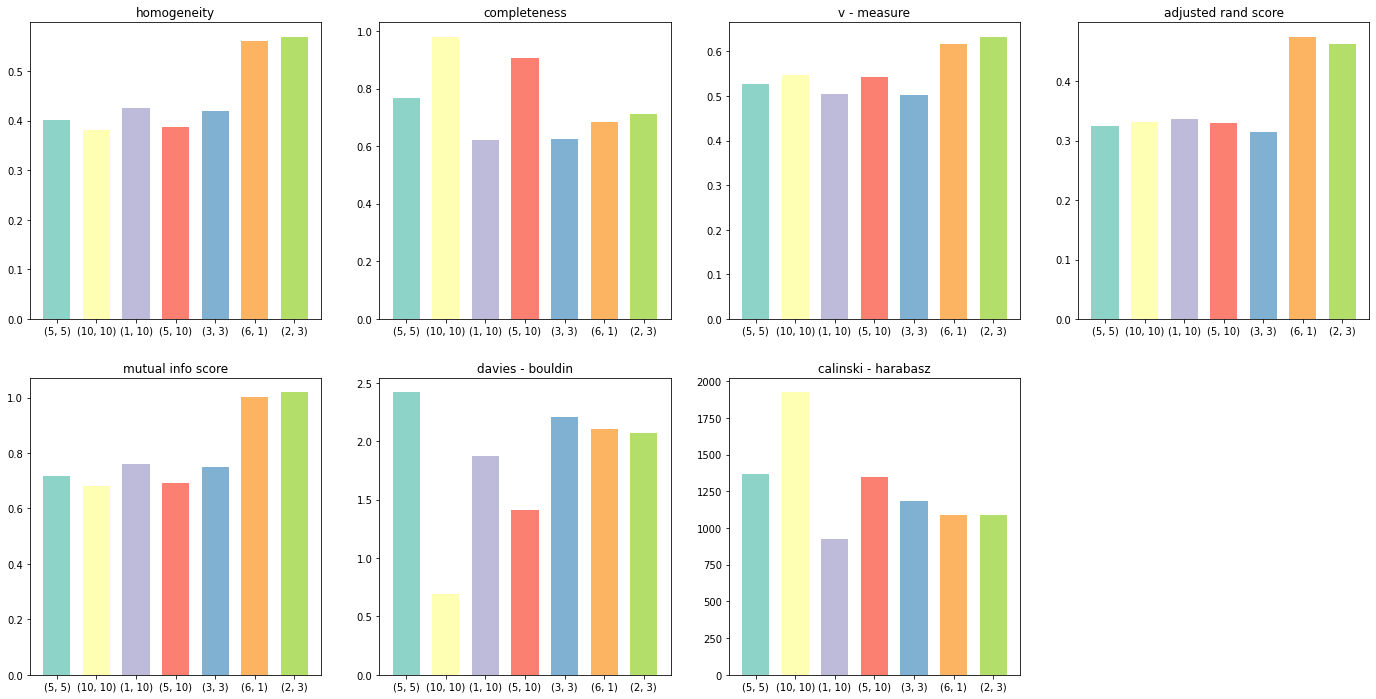

In [14]:
grids = [(5,5), (10,10), (1,10), (5,10), (3,3), (6,1), (2,3)]
np.random.seed(420)
df1, models1 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 6, iterations = 32, width = 1/2)

plot_scores(df1)

faworytem wydaje się być architektura o wymiarach 6x1

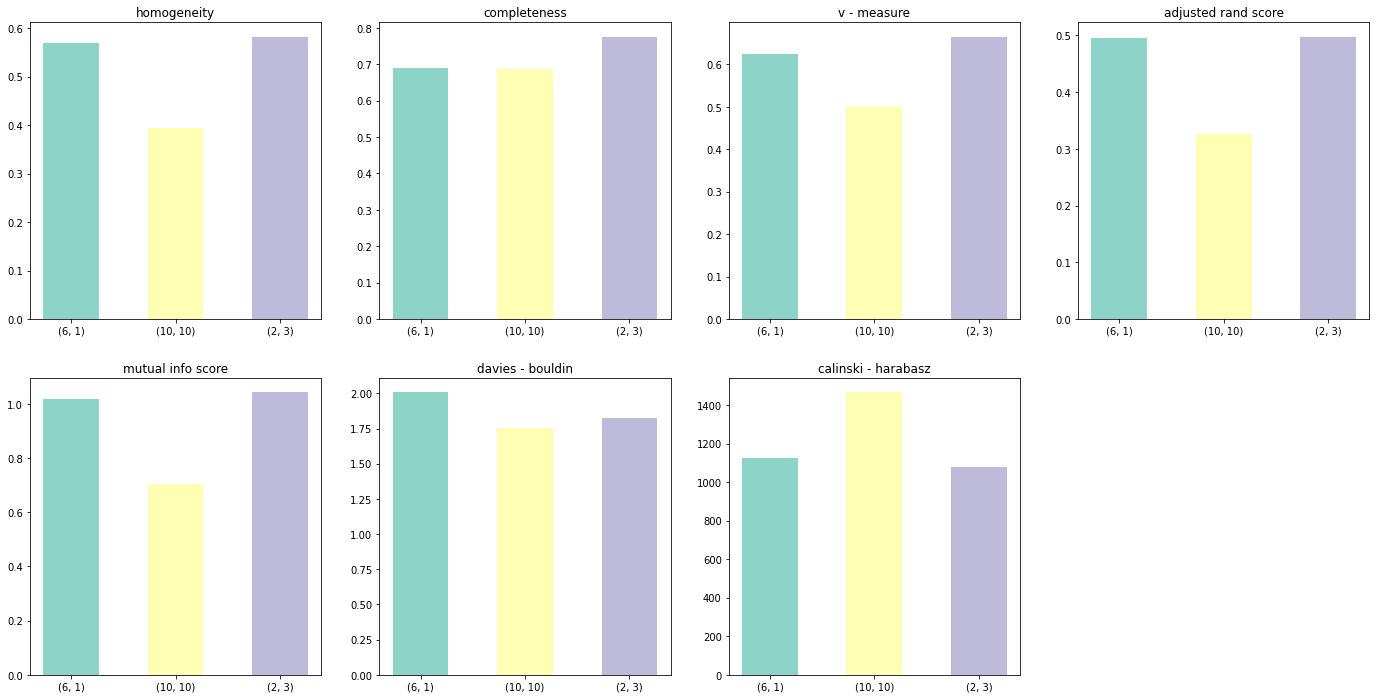

In [17]:
np.random.seed(420)
grids = [(6,1), (10,10), (2,3)]
tmp, models1_long = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 6, iterations = 200, width = 1/5)
plot_scores(tmp)

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz
"(6, 1)",0.570711,0.660637,0.612390,0.490449,1.018078,2.077603,2974.597961
"(10, 10)",0.393566,0.686427,0.500290,0.323184,0.702074,1.638222,2318.911626
"(2, 3)",0.579709,0.719621,0.642132,0.505915,1.034130,1.842841,2891.147389


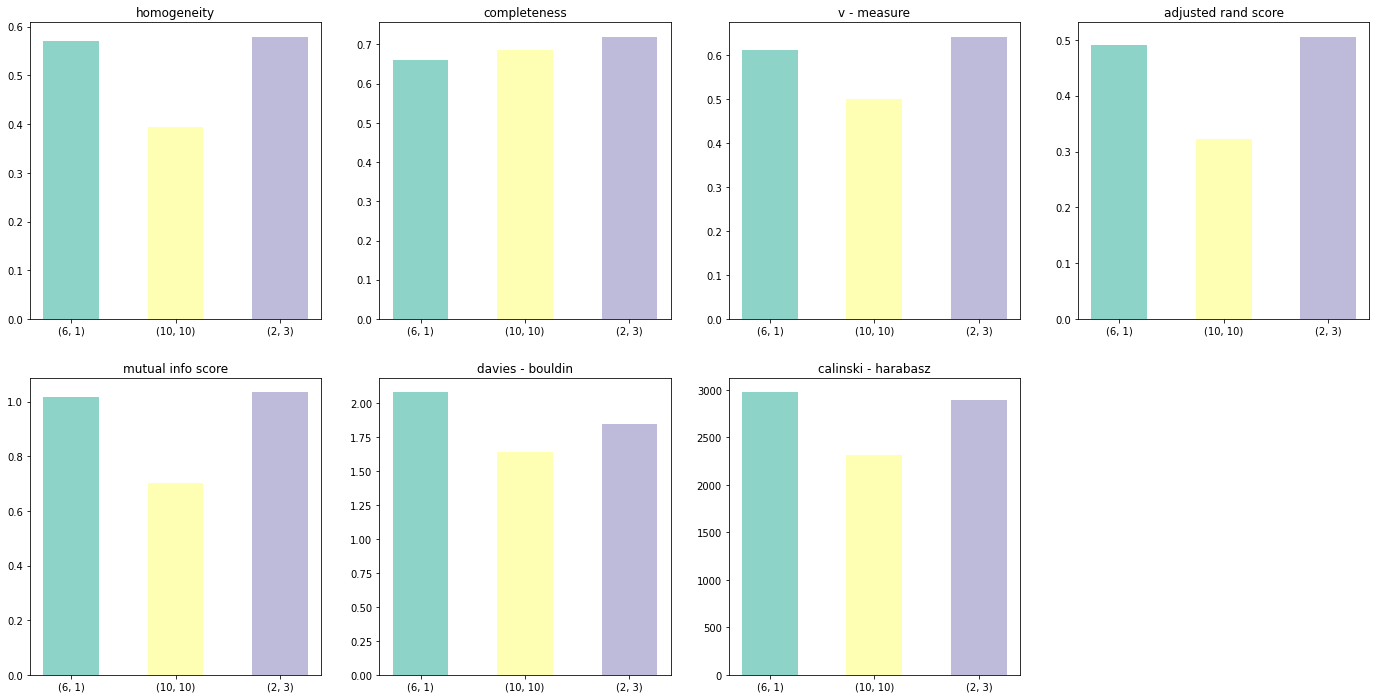

In [18]:
scores = []
score_fun_ext = {
            'homogeneity' : homogeneity_score,
            'completeness' : completeness_score,
            'v - measure' : v_measure_score,
            'adjusted rand score' : adjusted_rand_score,
            'mutual info score' : mutual_info_score
        }
score_fun_int = {
    'davies - bouldin' : davies_bouldin_score,
    'calinski - harabasz' : calinski_harabasz_score
}
for model in models1_long:
    c = model.test(X_train)
    values = {}
    for name, fun in score_fun_ext.items():
        eval = fun(y_train.flatten(), c)
        values[name] = eval
    
    for name, fun in score_fun_int.items():
        eval = fun(X_train, c)
        values[name] = eval
    scores.append(values)
train = pd.DataFrame(scores)
train.index = grids
plot_scores(train)
train

6 x 1
10 x 10
2 x 3


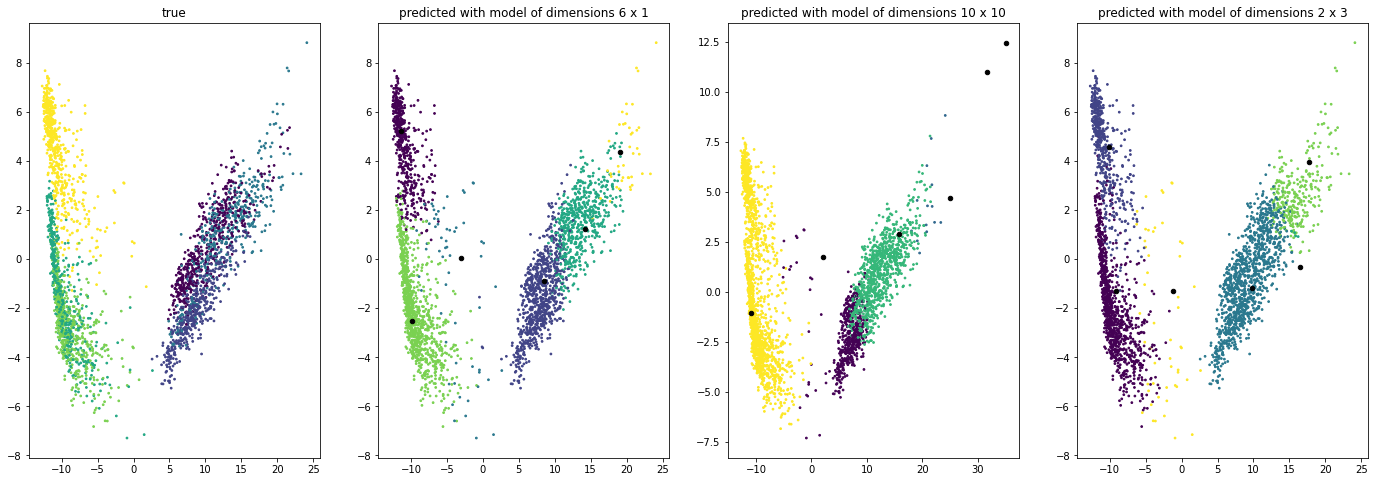

In [19]:
plot_pca(models1_long, X_test, y_test)

## topologia prostokątna, kapelusz meksykański jako funkcja sąsiedztwa

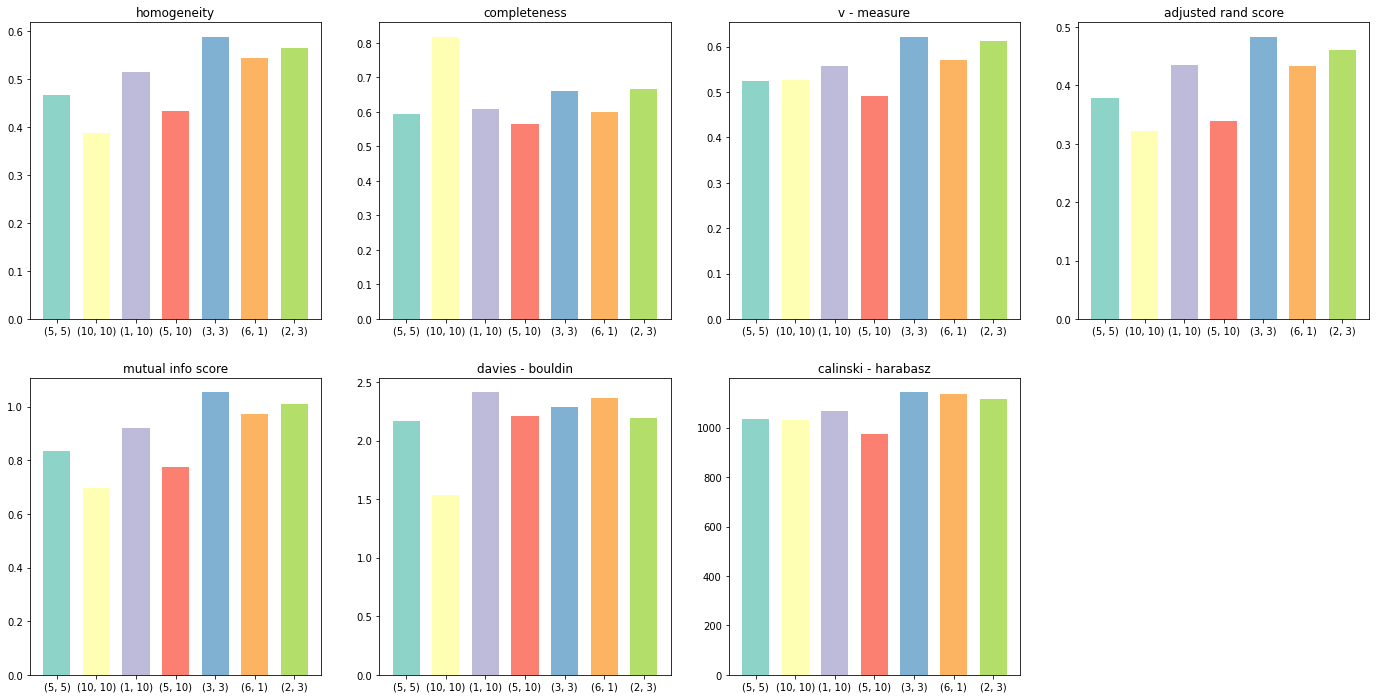

In [20]:
grids = [(5,5), (10,10), (1,10), (5,10), (3,3), (6,1), (2,3)]
np.random.seed(420)
df2, models2 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 6, iterations = 32, width = 1/10, method = 'mexican')
plot_scores(df2)

Najlepsze wytrenujmy na większej liczbie iteracji:

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz
"(3, 3)",0.522133,0.652813,0.580206,0.460380,0.933837,2.416347,1317.131482
"(6, 1)",0.473387,0.544817,0.506596,0.317761,0.846654,2.304011,1086.656884
"(2, 3)",0.584453,0.768721,0.664041,0.491848,1.045296,2.017002,1077.190663


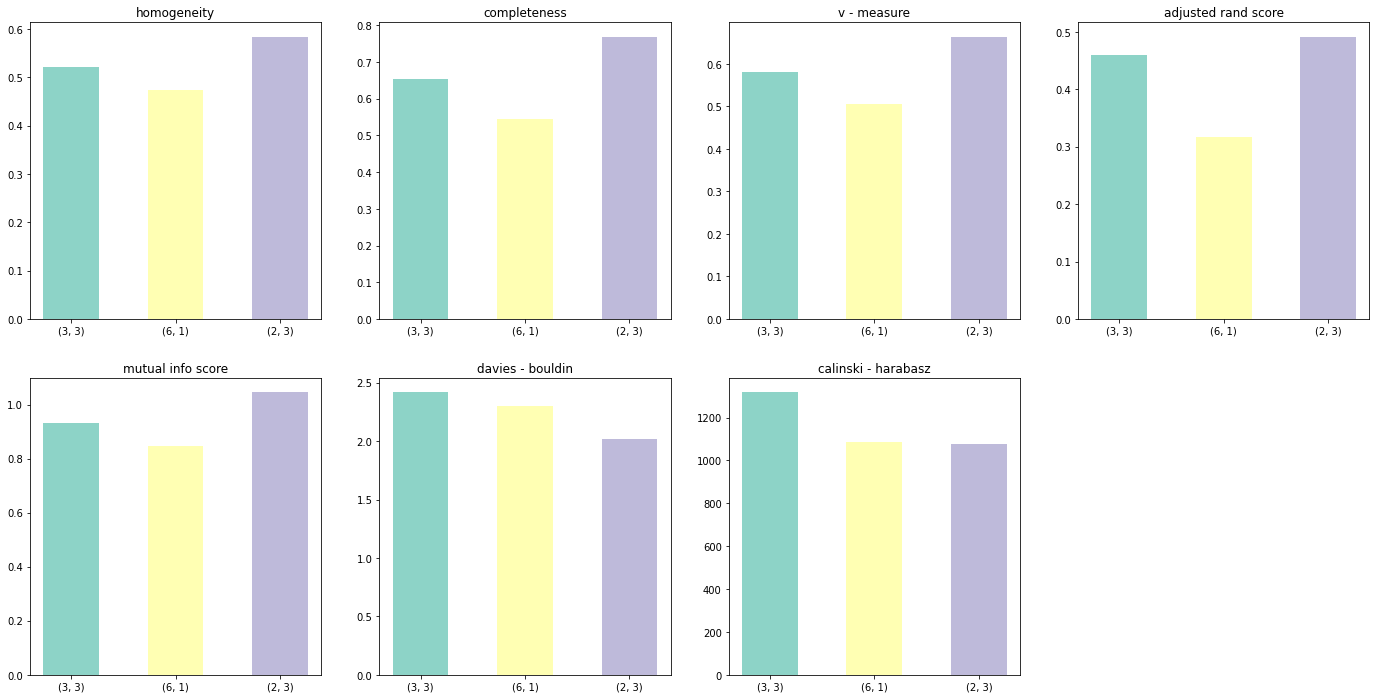

In [21]:
np.random.seed(420)
grids = [(3,3), (6,1), (2,3)]
tmp, models2_long = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 6, iterations = 200, width = 1/5, method = 'mexican')
plot_scores(tmp)
tmp

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz
"(3, 3)",0.496567,0.581015,0.535482,0.408640,0.885815,2.166890,2817.624512
"(6, 1)",0.459782,0.521665,0.488773,0.295738,0.820195,2.223541,2870.783705
"(2, 3)",0.572703,0.692966,0.627121,0.489890,1.021633,1.926006,2894.380961


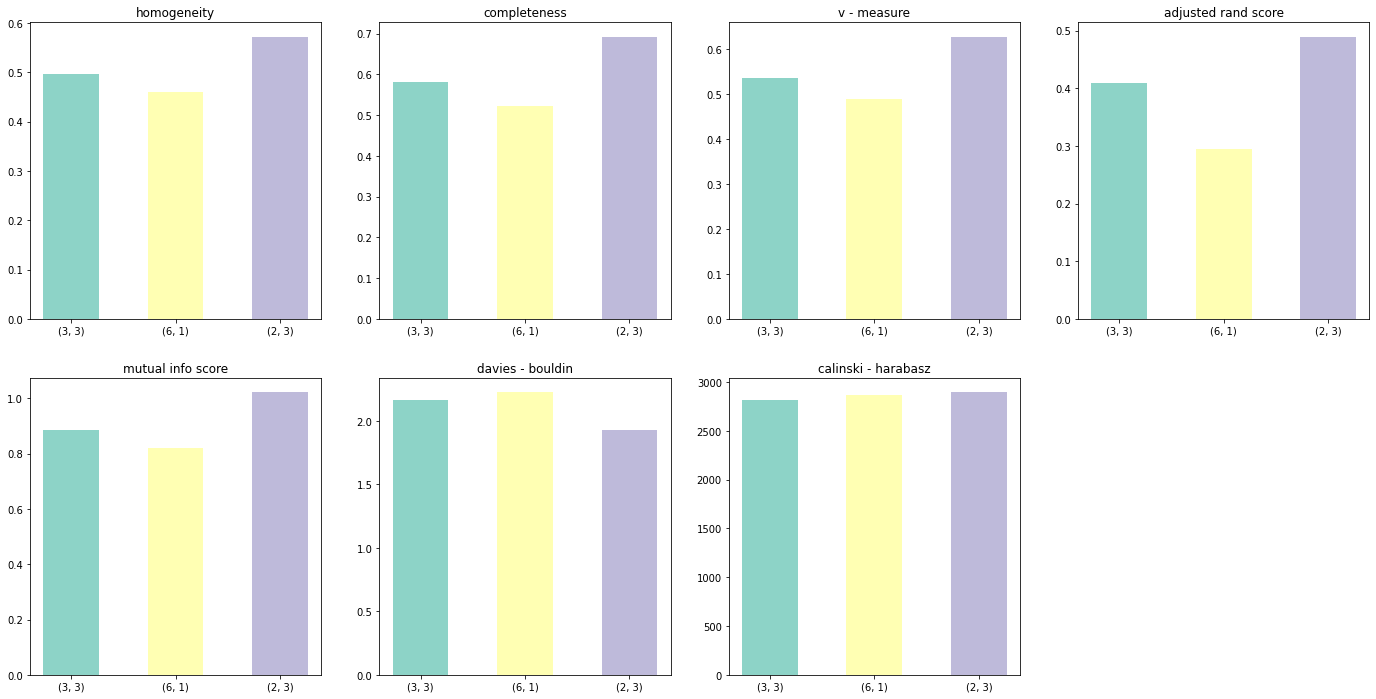

In [22]:
scores = []
score_fun_ext = {
            'homogeneity' : homogeneity_score,
            'completeness' : completeness_score,
            'v - measure' : v_measure_score,
            'adjusted rand score' : adjusted_rand_score,
            'mutual info score' : mutual_info_score
        }
score_fun_int = {
    'davies - bouldin' : davies_bouldin_score,
    'calinski - harabasz' : calinski_harabasz_score
}
for model in models2_long:
    c = model.test(X_train)
    values = {}
    for name, fun in score_fun_ext.items():
        eval = fun(y_train.flatten(), c)
        values[name] = eval
    
    for name, fun in score_fun_int.items():
        eval = fun(X_train, c)
        values[name] = eval
    scores.append(values)
train = pd.DataFrame(scores)
train.index = grids
plot_scores(train)
train

3 x 3
6 x 1
2 x 3


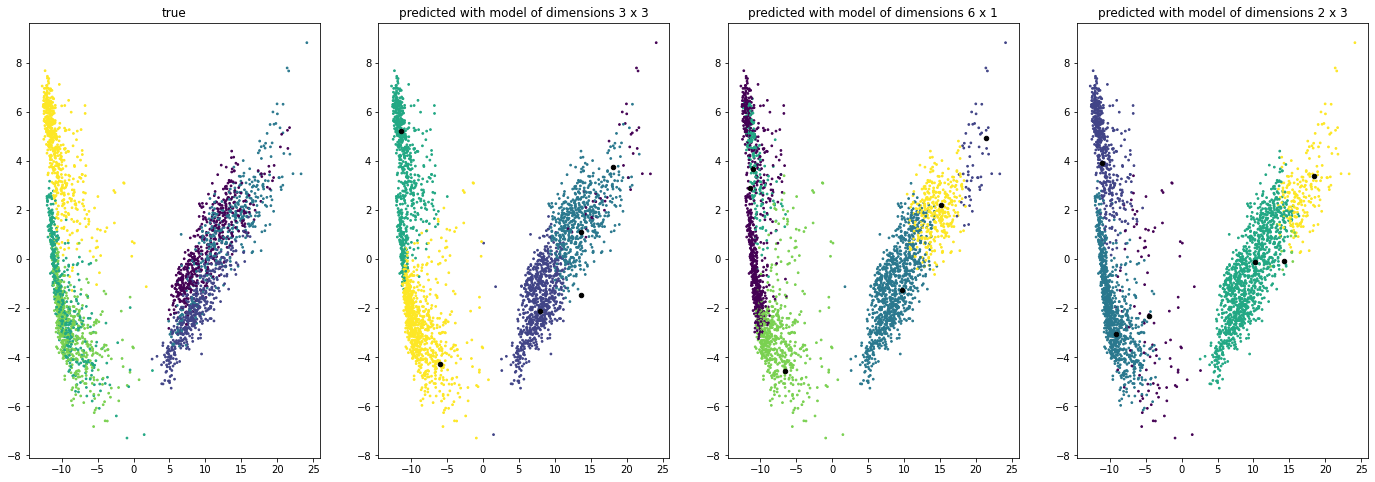

In [23]:
plot_pca(models2_long, X_test, y_test)

## topologia sześciokąta, gaussowska funkcja sąsiedztwa

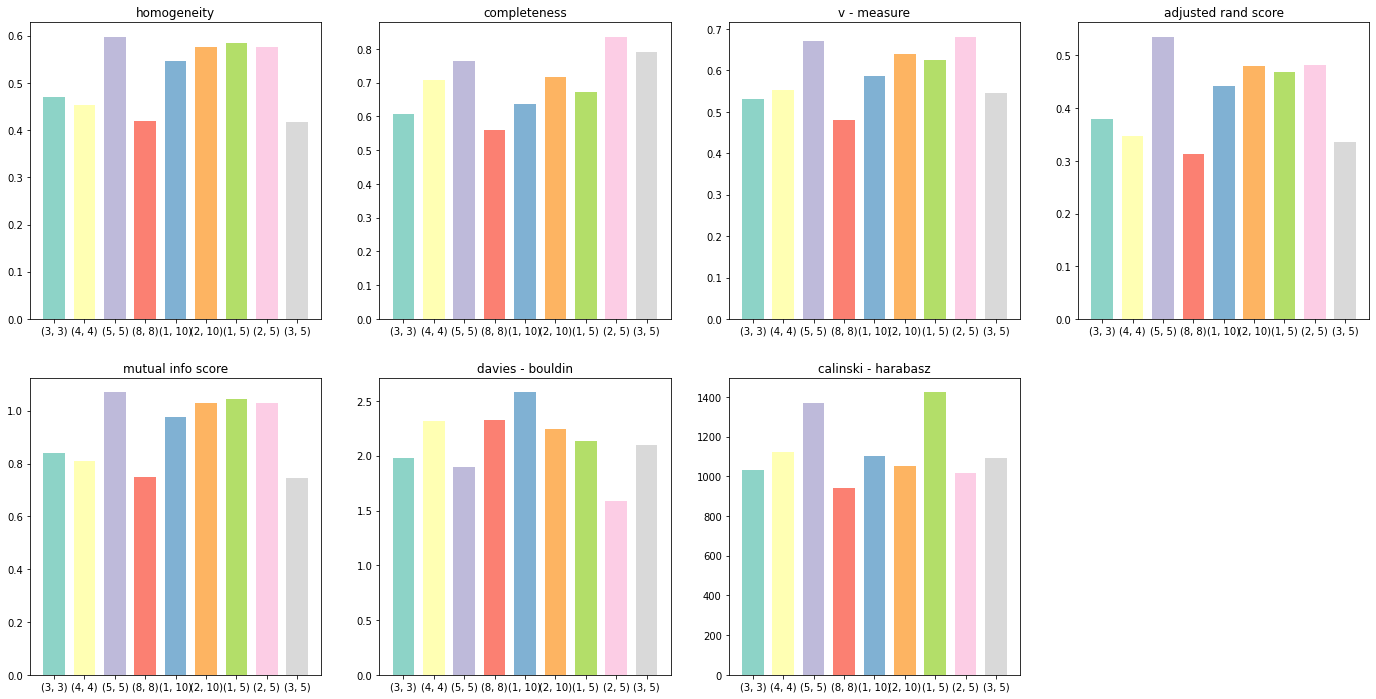

In [24]:
grids = [(3,3),(4,4),(5,5), (8,8), (1,10), (2,10), (1,5), (2,5), (3,5)]
np.random.seed(420)
df3, models3 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 6, iterations = 32, width = 1/2, gridtype='hexagon')
plot_scores(df3)

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz
"(5, 5)",0.389092,0.935053,0.549520,0.331475,0.695893,1.828587,795.286072
"(2, 5)",0.419764,0.704946,0.526199,0.323788,0.750749,2.094012,873.758714


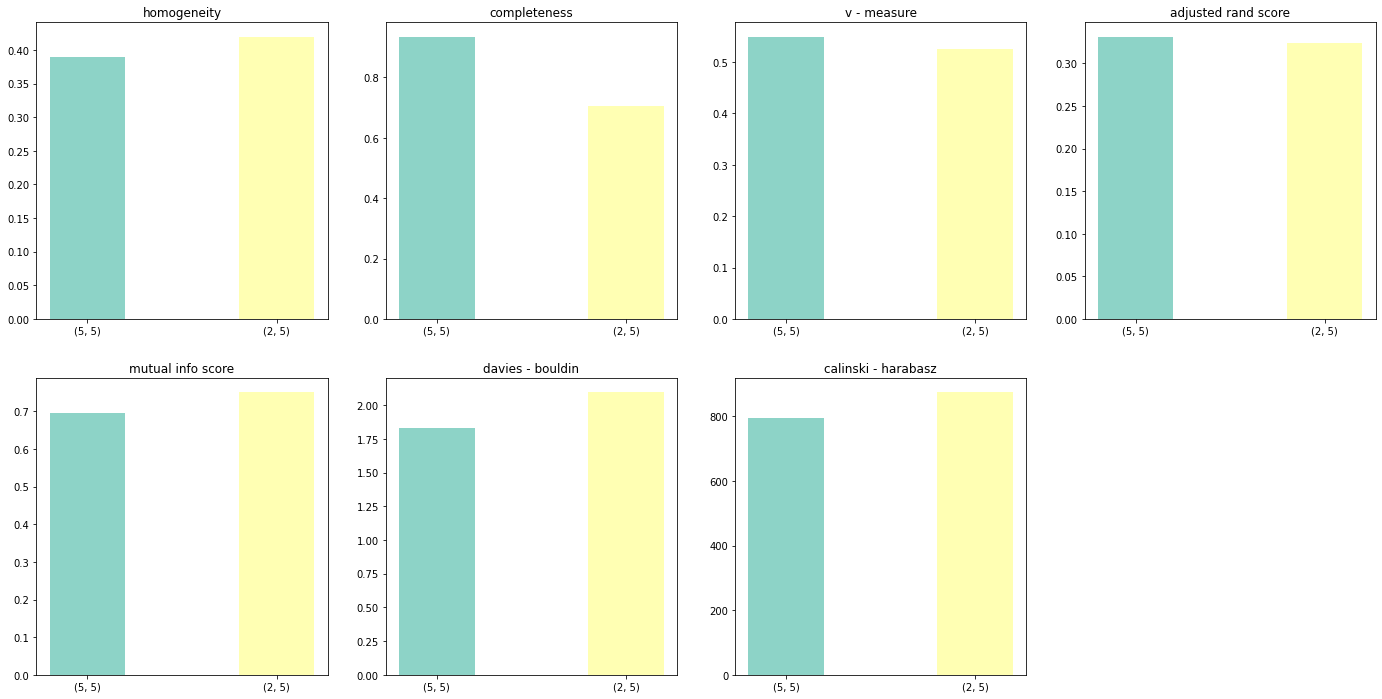

In [25]:
np.random.seed(420)
grids = [(5,5), (2,5)]
tmp, models3_long = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 6, iterations = 200, width = 1/5, gridtype = 'hexagon')
plot_scores(tmp)
tmp

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz
"(5, 5)",0.393375,0.777559,0.522442,0.321134,0.701733,1.798829,2265.893554
"(2, 5)",0.425480,0.621782,0.505233,0.321782,0.759004,2.315181,2498.325009


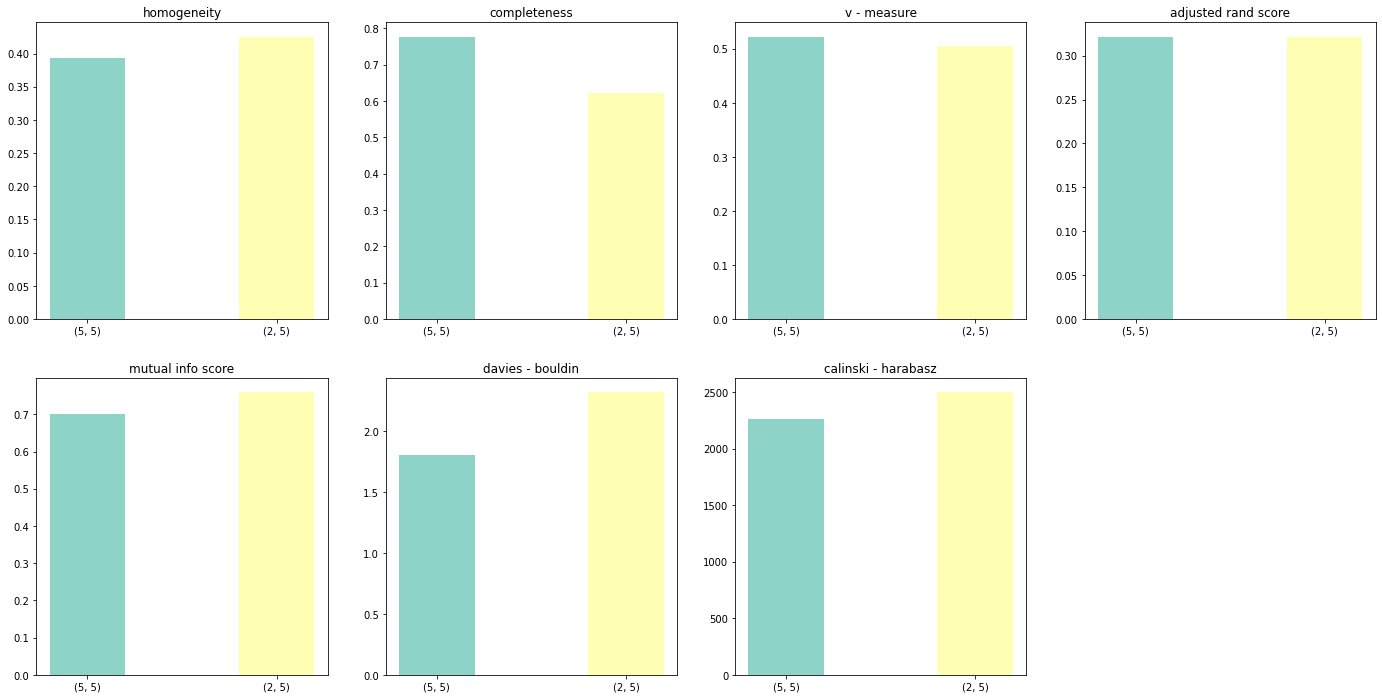

In [26]:
scores = []
score_fun_ext = {
            'homogeneity' : homogeneity_score,
            'completeness' : completeness_score,
            'v - measure' : v_measure_score,
            'adjusted rand score' : adjusted_rand_score,
            'mutual info score' : mutual_info_score
        }
score_fun_int = {
    'davies - bouldin' : davies_bouldin_score,
    'calinski - harabasz' : calinski_harabasz_score
}
for model in models3_long:
    c = model.test(X_train)
    values = {}
    for name, fun in score_fun_ext.items():
        eval = fun(y_train.flatten(), c)
        values[name] = eval
    
    for name, fun in score_fun_int.items():
        eval = fun(X_train, c)
        values[name] = eval
    scores.append(values)
train = pd.DataFrame(scores)
train.index = grids
plot_scores(train)
train

5 x 5
2 x 5


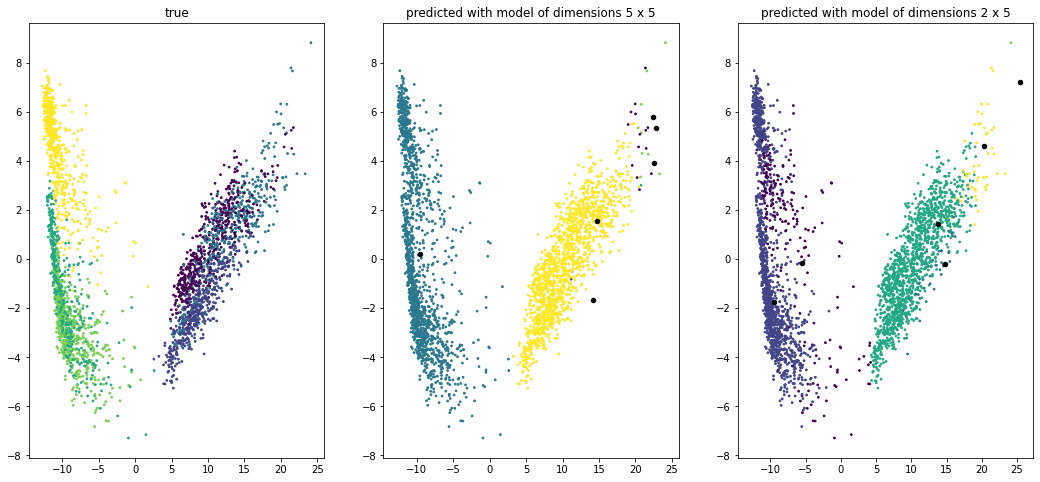

In [27]:
plot_pca(models3_long, X_test, y_test)

faworytem zdaje się być architektura o wymiarach 1x10

## topologia sześciokąta, kapelusz meksykański jako funkcja sąsiedztwa

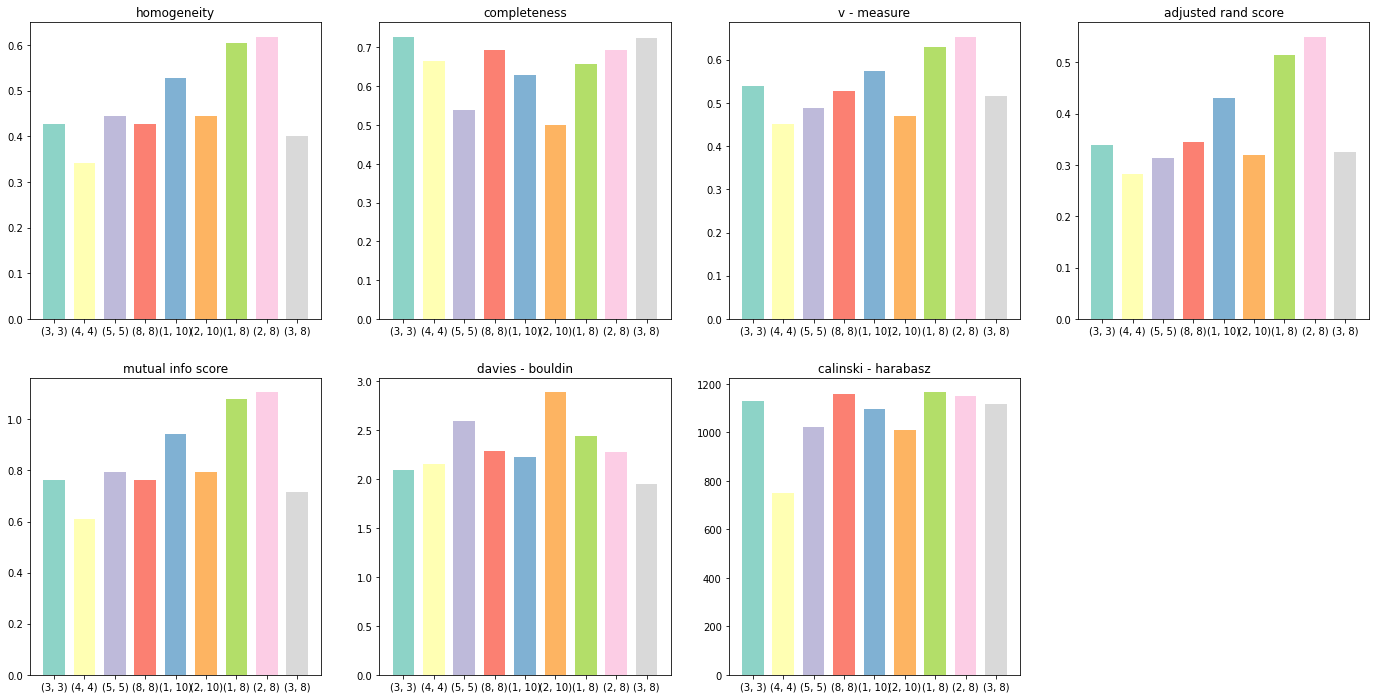

In [28]:
grids = [(3,3),(4,4),(5,5), (8,8), (1,10), (2,10), (1,8), (2,8), (3,8)]
np.random.seed(420)
df4, models4 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 6, iterations = 32, width = 1/10, method = 'mexican', gridtype='hexagon')
plot_scores(df4)

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz
"(4, 4)",0.386247,0.950570,0.549297,0.331355,0.690805,1.069646,1314.822435
"(2, 8)",0.425184,0.661676,0.517701,0.335859,0.760443,1.923532,940.270474


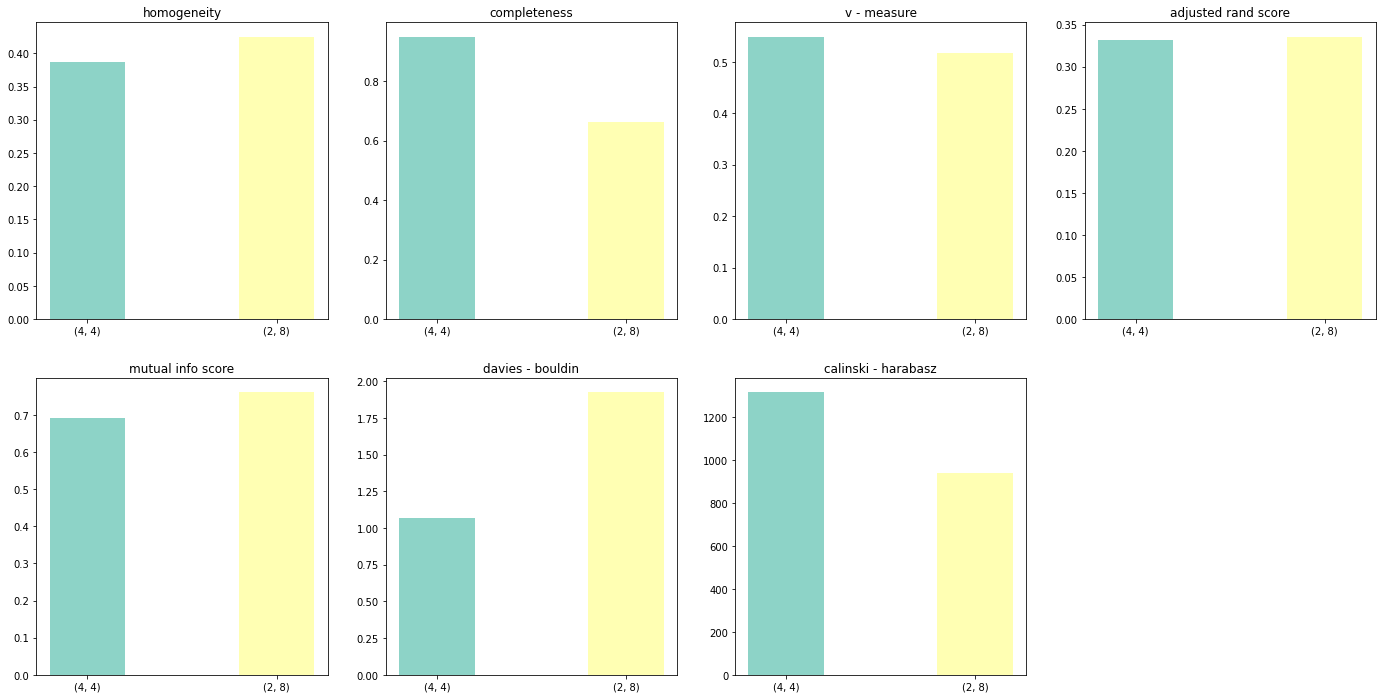

In [29]:
np.random.seed(420)
grids = [(4,4), (2,8)]
tmp, models4_long = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 6, iterations = 200, width = 1/10, gridtype = 'hexagon', method = 'mexican')
plot_scores(tmp)
tmp

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz
"(4, 4)",0.383132,0.841734,0.526580,0.325064,0.683460,1.432983,2194.586682
"(2, 8)",0.419072,0.623161,0.501135,0.327885,0.747573,1.806758,2540.882902


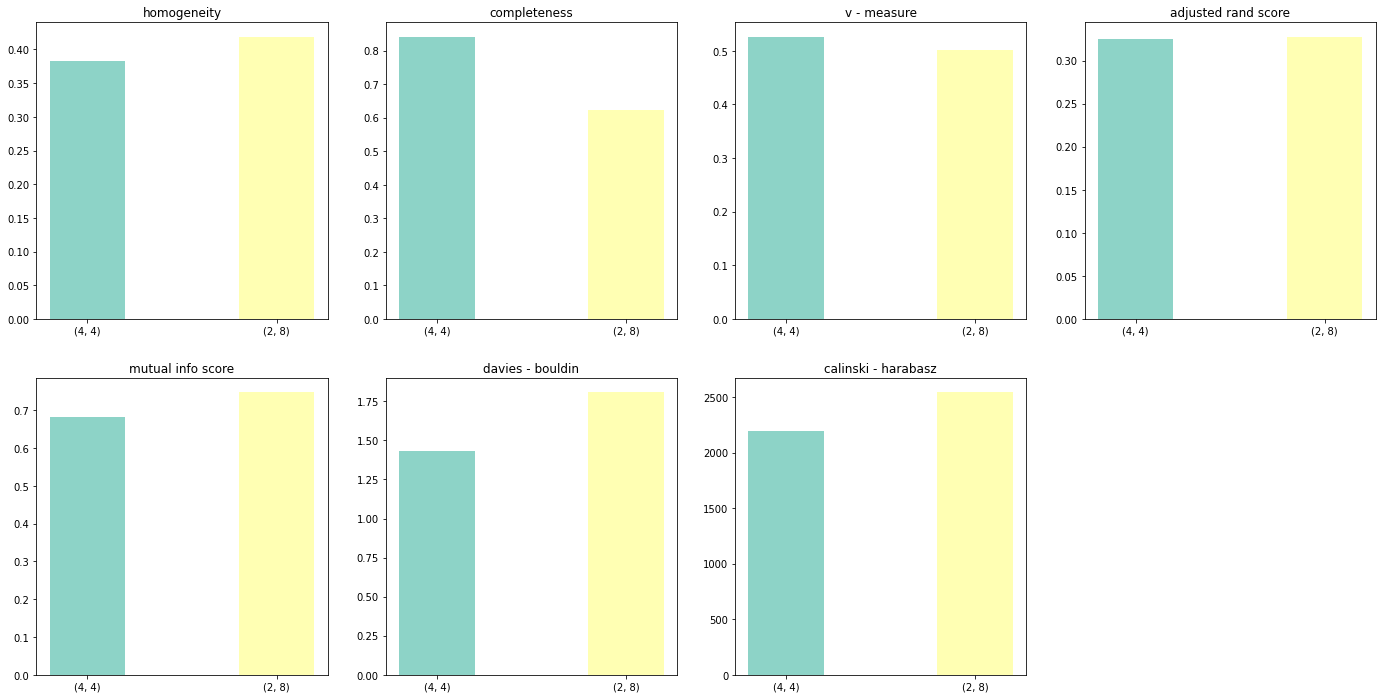

In [30]:
scores = []
score_fun_ext = {
            'homogeneity' : homogeneity_score,
            'completeness' : completeness_score,
            'v - measure' : v_measure_score,
            'adjusted rand score' : adjusted_rand_score,
            'mutual info score' : mutual_info_score
        }
score_fun_int = {
    'davies - bouldin' : davies_bouldin_score,
    'calinski - harabasz' : calinski_harabasz_score
}
for model in models4_long:
    c = model.test(X_train)
    values = {}
    for name, fun in score_fun_ext.items():
        eval = fun(y_train.flatten(), c)
        values[name] = eval
    
    for name, fun in score_fun_int.items():
        eval = fun(X_train, c)
        values[name] = eval
    scores.append(values)
train = pd.DataFrame(scores)
train.index = grids
plot_scores(train)
train

4 x 4
2 x 8


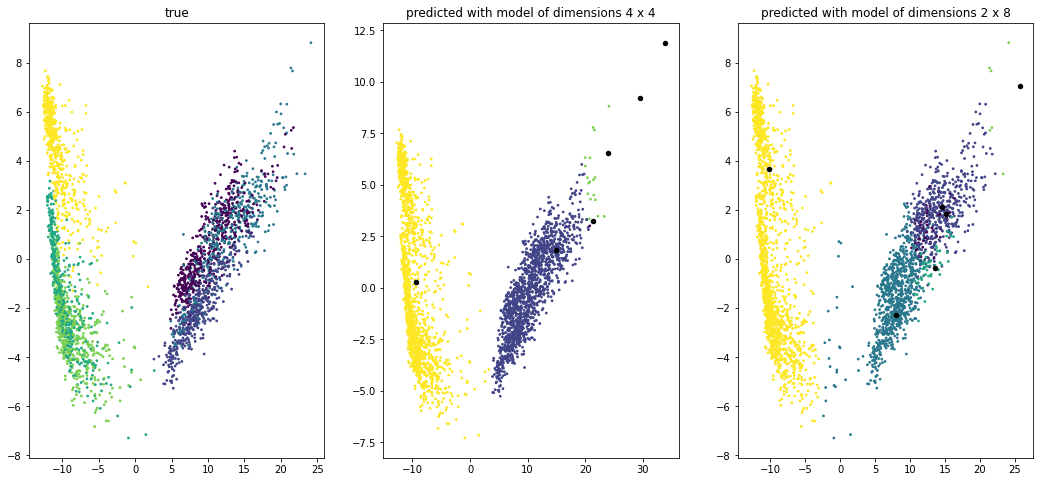

In [31]:
plot_pca(models4_long, X_test, y_test)

2x3 oraz 1x10 wydają się być interesującymi nas architekturami

# dataset MNIST

dane podzielone są na 10 klastrów (cyfry w systemie dziesiętnym)

In [32]:
X_train = pd.read_csv('../dane_kohonen/mnist/mnist_train.csv')
y_train = np.asarray(X_train['label'])
X_train = np.asarray(X_train.drop(columns=['label']))
X_test = pd.read_csv('../dane_kohonen/mnist/mnist_test.csv')
y_test = np.asarray(X_test['label'])
X_test = X_test.drop(columns = ['label'])


# normalization
X_test = np.asarray((X_test - X_train.mean())/X_train.std())
X_train = np.asarray((X_train - X_train.mean())/X_train.std())
X_train.shape

(60000, 784)

In [33]:
pca = PCA(2)
pca.fit(X_test)
pca.explained_variance_ratio_

array([0.10047663, 0.07544487])

W tym problemie nie ma sensu PCA

## topologia prostokątna, gaussowska funkcja sąsiedztwa

sprawdzimy najpierw, ile klastrów model uzna za najbardziej optymalny podział:

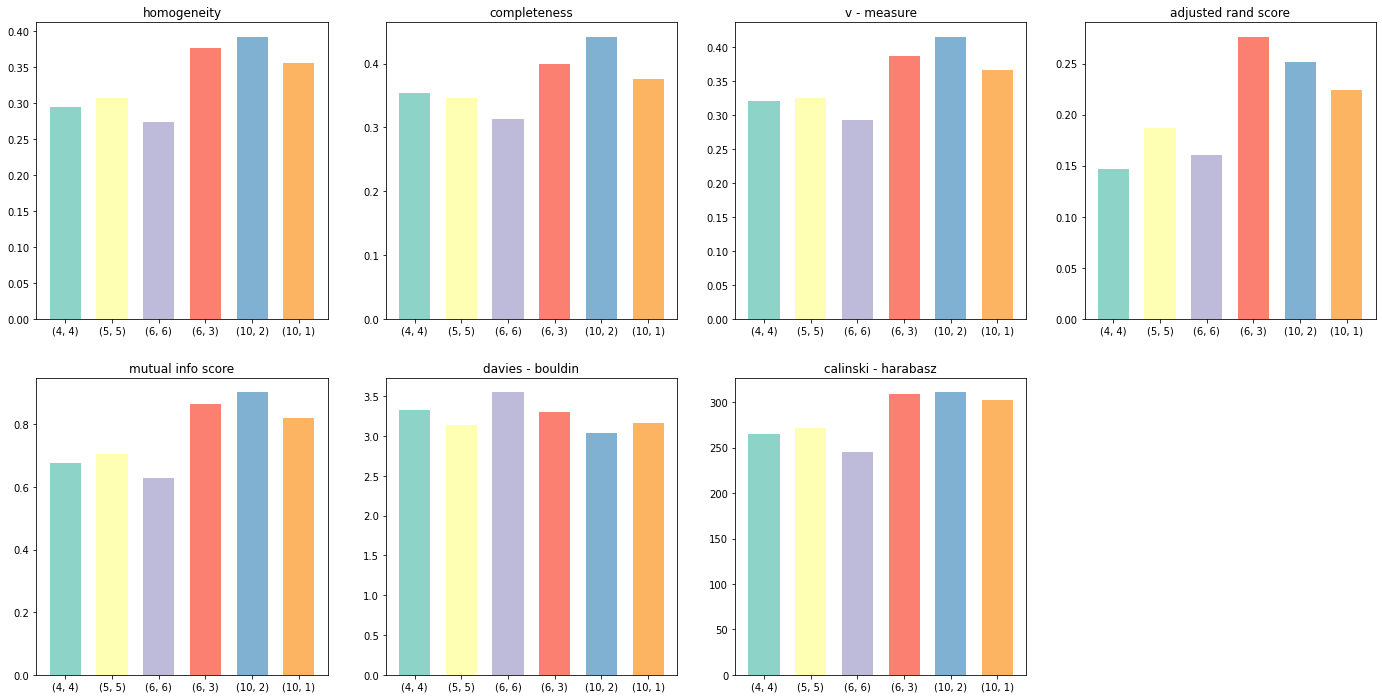

In [34]:
grids = [(4,4), (5,5), (6,6), (6,3), (10,2), (10,1)]
np.random.seed(420) 
df1, models1 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 10, width = 1/2)

plot_scores(df1)

faworytem wydaje się być architektura o wymiarach 10x2

In [35]:
np.random.seed(420)
grids = [(10,2)]
tmp, models1_long = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/2)
tmp

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz
"(10, 2)",0.350353,0.408804,0.377328,0.211839,0.806108,3.337643,258.762288


In [36]:
scores = []
score_fun_ext = {
            'homogeneity' : homogeneity_score,
            'completeness' : completeness_score,
            'v - measure' : v_measure_score,
            'adjusted rand score' : adjusted_rand_score,
            'mutual info score' : mutual_info_score
        }
score_fun_int = {
    'davies - bouldin' : davies_bouldin_score,
    'calinski - harabasz' : calinski_harabasz_score
}
for model in models1_long:
    c = model.test(X_train)
    values = {}
    for name, fun in score_fun_ext.items():
        eval = fun(y_train.flatten(), c)
        values[name] = eval
    
    for name, fun in score_fun_int.items():
        eval = fun(X_train, c)
        values[name] = eval
    scores.append(values)
train = pd.DataFrame(scores)
train.index = grids
train

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz
"(10, 2)",0.345252,0.405741,0.37306,0.205333,0.79448,3.372983,1534.265906


## topologia prostokątna, kapelusz meksykański jako funkcja sąsiedztwa

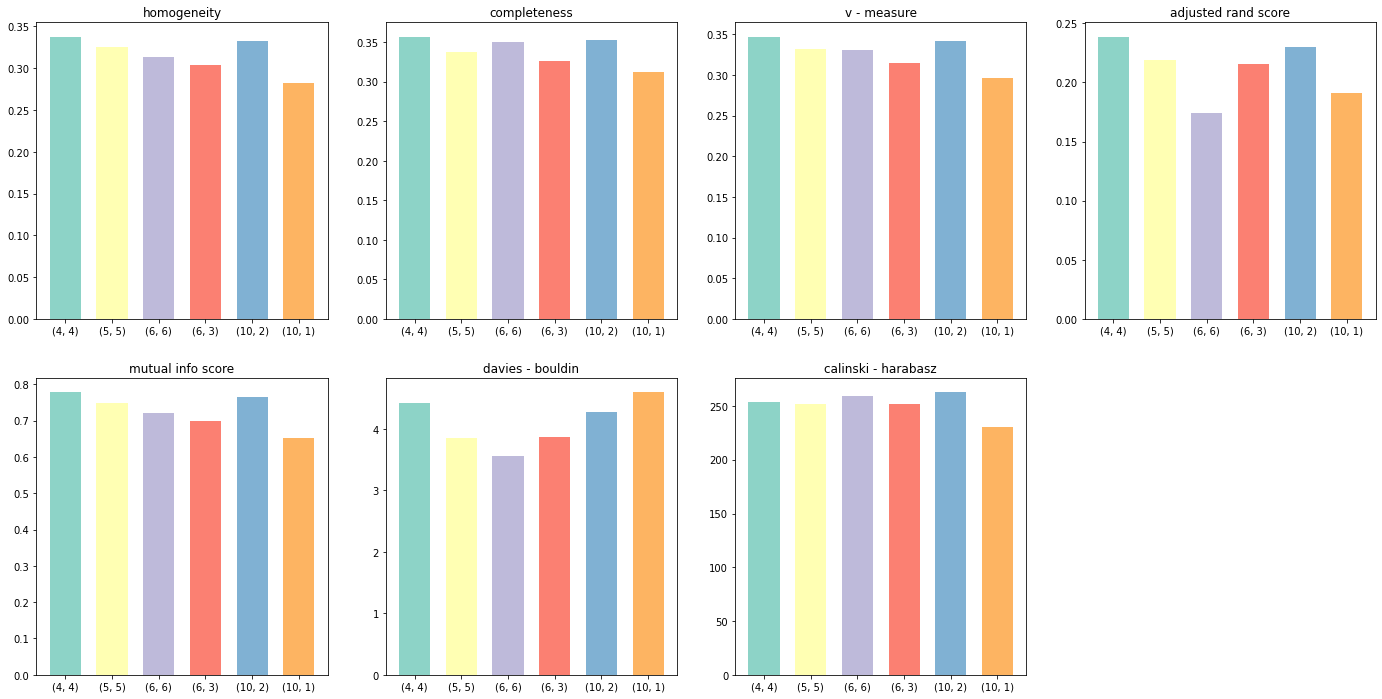

In [37]:
grids = [(4,4), (5,5), (6,6), (6,3), (10,2), (10,1)]
np.random.seed(420)
df2, models2 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 10, width = 1/10, method = 'mexican')
plot_scores(df2)

Najlepsze wytrenujmy na większej liczbie iteracji:

In [38]:
np.random.seed(420)
grids = [(10,3)]
tmp, models2_long = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/10, method = 'mexican')
tmp

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz
"(10, 3)",0.378823,0.402044,0.390088,0.255478,0.871614,3.315722,307.449002


In [39]:
scores = []
score_fun_ext = {
            'homogeneity' : homogeneity_score,
            'completeness' : completeness_score,
            'v - measure' : v_measure_score,
            'adjusted rand score' : adjusted_rand_score,
            'mutual info score' : mutual_info_score
        }
score_fun_int = {
    'davies - bouldin' : davies_bouldin_score,
    'calinski - harabasz' : calinski_harabasz_score
}
for model in models2_long:
    c = model.test(X_train)
    values = {}
    for name, fun in score_fun_ext.items():
        eval = fun(y_train.flatten(), c)
        values[name] = eval
    
    for name, fun in score_fun_int.items():
        eval = fun(X_train, c)
        values[name] = eval
    scores.append(values)
train = pd.DataFrame(scores)
train.index = grids
train

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz
"(10, 3)",0.374002,0.394999,0.384213,0.2538,0.860637,3.384181,1804.634386


## topologia sześciokąta, gaussowska funkcja sąsiedztwa

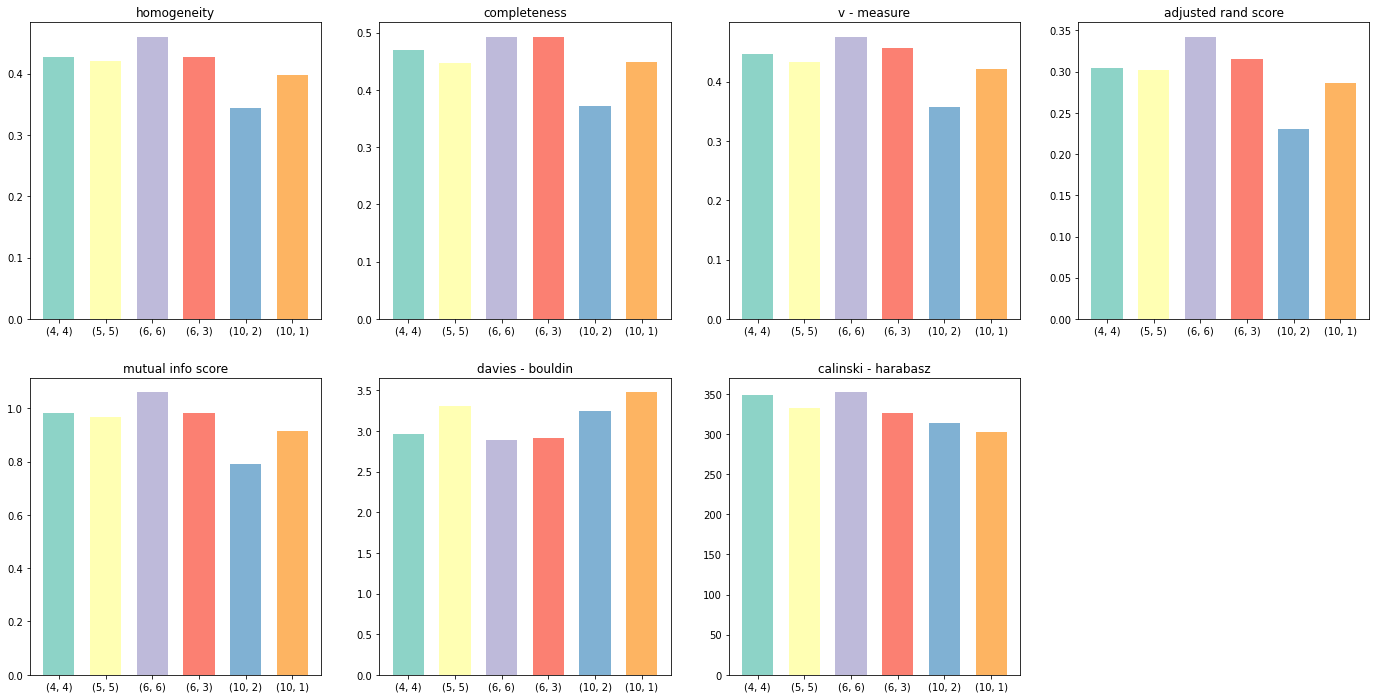

In [40]:
grids = [(4,4), (5,5), (6,6), (6,3), (10,2), (10,1)]
np.random.seed(420)
df3, models3 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 10, width = 1/2, gridtype='hexagon')
plot_scores(df3)

In [41]:
np.random.seed(420)
grids = [(6,6)]
tmp, models3_long = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/2, gridtype = 'hexagon')
tmp

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz
"(6, 6)",0.405259,0.432065,0.418233,0.277217,0.932439,3.26764,313.283647


In [42]:
scores = []
score_fun_ext = {
            'homogeneity' : homogeneity_score,
            'completeness' : completeness_score,
            'v - measure' : v_measure_score,
            'adjusted rand score' : adjusted_rand_score,
            'mutual info score' : mutual_info_score
        }
score_fun_int = {
    'davies - bouldin' : davies_bouldin_score,
    'calinski - harabasz' : calinski_harabasz_score
}
for model in models3_long:
    c = model.test(X_train)
    values = {}
    for name, fun in score_fun_ext.items():
        eval = fun(y_train.flatten(), c)
        values[name] = eval
    
    for name, fun in score_fun_int.items():
        eval = fun(X_train, c)
        values[name] = eval
    scores.append(values)
train = pd.DataFrame(scores)
train.index = grids
train

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz
"(6, 6)",0.399027,0.427614,0.412826,0.267935,0.918224,3.296872,1792.731854


faworytem zdaje się być architektura o wymiarach 1x10

## topologia sześciokąta, kapelusz meksykański jako funkcja sąsiedztwa

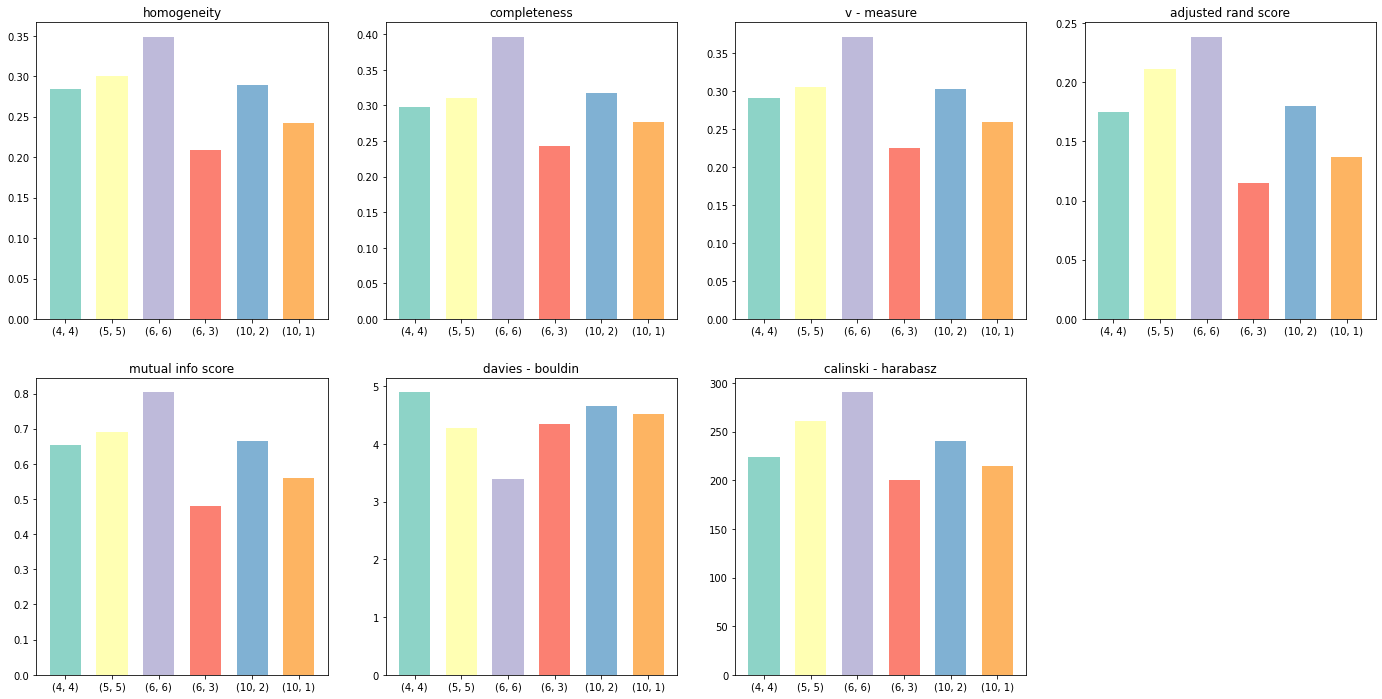

In [43]:
grids = [(4,4), (5,5), (6,6), (6,3), (10,2), (10,1)]
np.random.seed(420)
df4, models4 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 10, width = 1/10, method = 'mexican', gridtype='hexagon')
plot_scores(df4)

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz
"(6, 6)",0.422840,0.454004,0.437868,0.322799,0.972891,3.132090,332.725896
"(8, 8)",0.296027,0.352934,0.321986,0.170017,0.681114,3.299744,264.645647


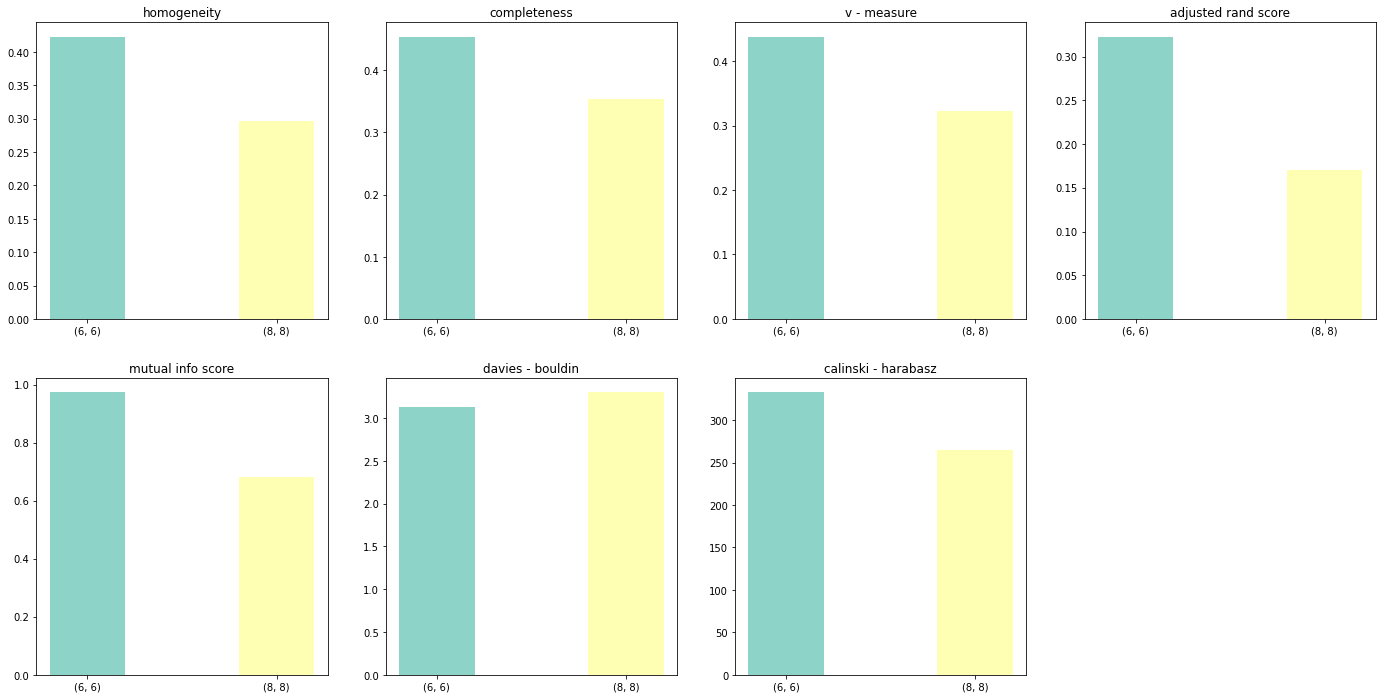

In [44]:
np.random.seed(420)
grids = [(6,6), (8,8)]
tmp, models4_long = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/10, gridtype = 'hexagon', method = 'mexican')
plot_scores(tmp)
tmp

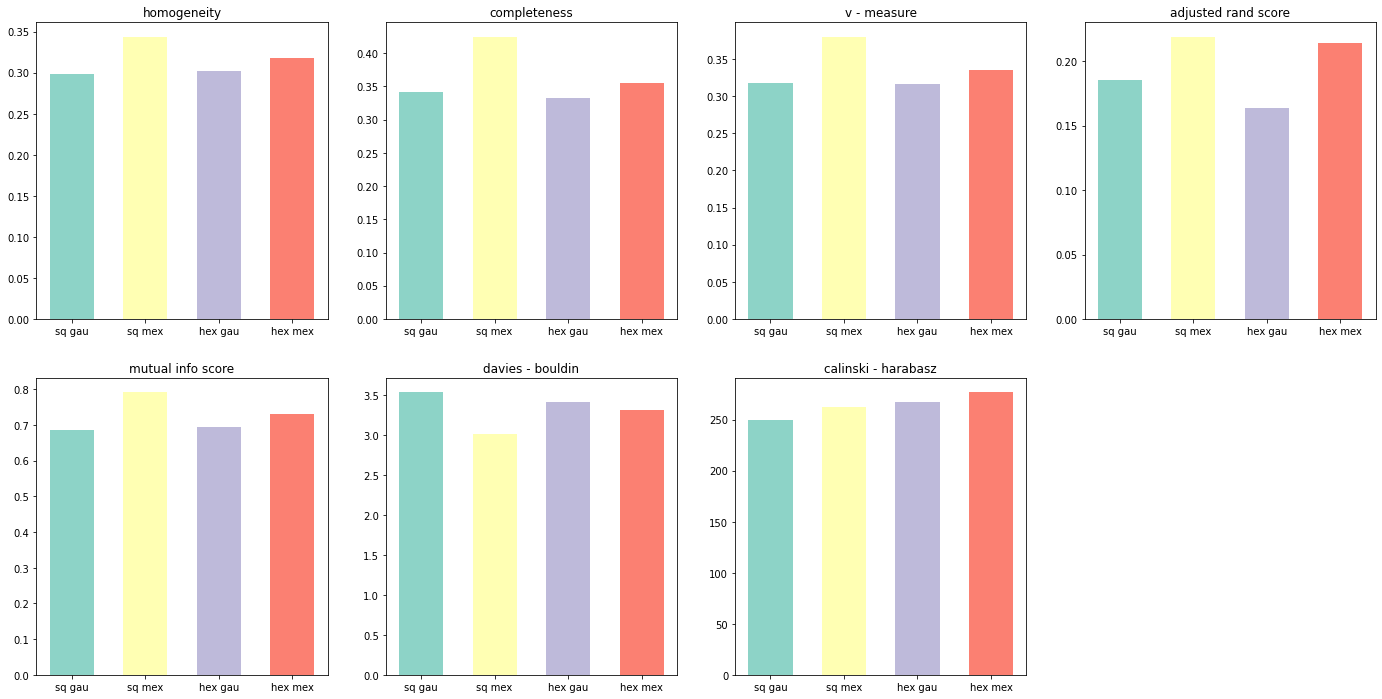

In [45]:
grids = (8,8)
eval1, model1 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/10)
eval2, model2 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/10, method = 'mexican')
eval3, model3 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/10, gridtype = 'hexagon')
eval4, model4 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/10, method = 'mexican', gridtype = 'hexagon')
df = pd.concat([eval1, eval2, eval3, eval4])
df.index = ['sq gau', 'sq mex', 'hex gau', 'hex mex']
plot_scores(df)

In [54]:
models = [model1[0], model2[0], model3[0], model4[0]]
scores = []
score_fun_ext = {
            'homogeneity' : homogeneity_score,
            'completeness' : completeness_score,
            'v - measure' : v_measure_score,
            'adjusted rand score' : adjusted_rand_score,
            'mutual info score' : mutual_info_score
        }
score_fun_int = {
    'davies - bouldin' : davies_bouldin_score,
    'calinski - harabasz' : calinski_harabasz_score
}
for model in models:
    c = model.test(X_train)
    values = {}
    for name, fun in score_fun_ext.items():
        eval = fun(y_train.flatten(), c)
        values[name] = eval
    
    for name, fun in score_fun_int.items():
        eval = fun(X_train, c)
        values[name] = eval
    scores.append(values)
train = pd.DataFrame(scores)
train.index = ['sq gau', 'sq mex', 'hex gau', 'hex mex']
train

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz
sq gau,0.273698,0.310939,0.291132,0.165121,0.629822,3.586614,1438.770676
sq mex,0.338159,0.413172,0.371921,0.207130,0.778157,3.067041,1557.207054
hex gau,0.307458,0.333500,0.319950,0.166981,0.707509,3.462516,1616.958269
hex mex,0.301031,0.339793,0.319239,0.195838,0.692720,3.367706,1592.147157


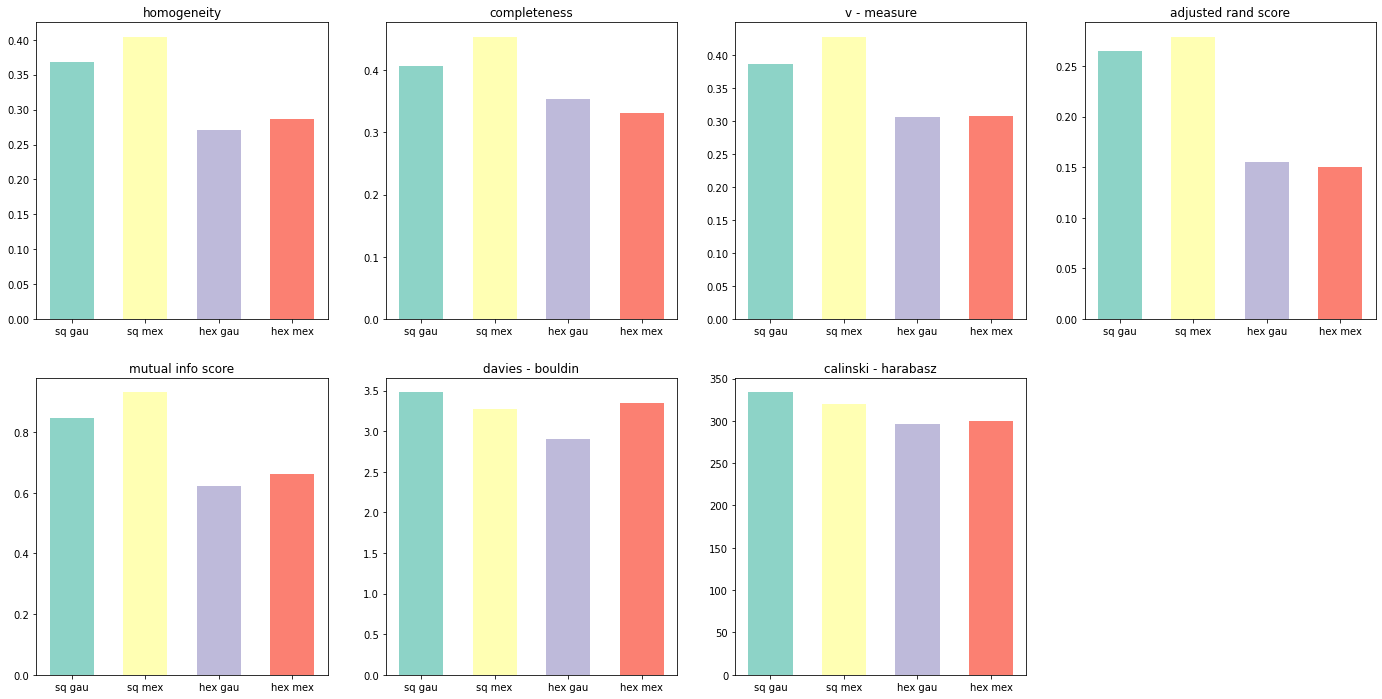

In [56]:
grids = (3,3)
eval1, model1 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/10)
eval2, model2 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/10, method = 'mexican')
eval3, model3 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/10, gridtype = 'hexagon')
eval4, model4 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/10, method = 'mexican', gridtype = 'hexagon')
df = pd.concat([eval1, eval2, eval3, eval4])
df.index = ['sq gau', 'sq mex', 'hex gau', 'hex mex']
plot_scores(df)

In [57]:
models = [model1[0], model2[0], model3[0], model4[0]]
scores = []
score_fun_ext = {
            'homogeneity' : homogeneity_score,
            'completeness' : completeness_score,
            'v - measure' : v_measure_score,
            'adjusted rand score' : adjusted_rand_score,
            'mutual info score' : mutual_info_score
        }
score_fun_int = {
    'davies - bouldin' : davies_bouldin_score,
    'calinski - harabasz' : calinski_harabasz_score
}
for model in models:
    c = model.test(X_train)
    values = {}
    for name, fun in score_fun_ext.items():
        eval = fun(y_train.flatten(), c)
        values[name] = eval
    
    for name, fun in score_fun_int.items():
        eval = fun(X_train, c)
        values[name] = eval
    scores.append(values)
train = pd.DataFrame(scores)
train.index = ['sq gau', 'sq mex', 'hex gau', 'hex mex']
train

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz
sq gau,0.357873,0.398576,0.377130,0.255082,0.823524,3.448858,1928.744456
sq mex,0.385964,0.437292,0.410028,0.259280,0.888164,3.329944,1847.665948
hex gau,0.255155,0.334700,0.289564,0.144447,0.587152,2.987342,1705.780378
hex mex,0.279595,0.323088,0.299772,0.144597,0.643392,3.434734,1742.227426


In [80]:
grids = [(4,4), (5,5), (6,6), (7,7), (8,8)]
eval1, model1 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 32, width = 1/10)
eval2, model2 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 32, width = 1/10, method = 'mexican')
eval3, model3 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 32, width = 1/10, gridtype = 'hexagon')
eval4, model4 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 32, width = 1/10, method = 'mexican', gridtype = 'hexagon')
eval1['gridsize'] = grids
eval2['gridsize'] = grids
eval3['gridsize'] = grids
eval4['gridsize'] = grids
eval1['gridtype'] = 'sq gau'
eval2['gridtype'] = 'sq mex'
eval3['gridtype'] = 'hex gau'
eval4['gridtype'] = 'hex mex'
df = pd.concat([eval1, eval2, eval3, eval4])
df.index =[a + ' ' + str(b) for a in ['sq gau', 'sq mex', 'hex gau', 'hex mex'] for b in grids]
df

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz,gridsize,gridtype
"sq gau (4, 4)",0.308517,0.344357,0.325453,0.165371,0.709850,3.130426,279.425082,"(4, 4)",sq gau
"sq gau (5, 5)",0.305737,0.394717,0.344575,0.137321,0.703454,3.116367,253.489085,"(5, 5)",sq gau
"sq gau (6, 6)",0.266542,0.325389,0.293041,0.141096,0.613274,3.272058,240.186432,"(6, 6)",sq gau
"sq gau (7, 7)",0.319687,0.366053,0.341302,0.202752,0.735551,3.350789,271.071248,"(7, 7)",sq gau
"sq gau (8, 8)",0.279766,0.359186,0.314540,0.134613,0.643700,3.018149,236.387711,"(8, 8)",sq gau
"sq mex (4, 4)",0.402675,0.421116,0.411689,0.308460,0.926493,3.260110,307.293422,"(4, 4)",sq mex
"sq mex (5, 5)",0.366608,0.399347,0.382278,0.207703,0.843509,3.246724,296.430693,"(5, 5)",sq mex
"sq mex (6, 6)",0.330839,0.372930,0.350625,0.174450,0.761209,3.321940,272.938689,"(6, 6)",sq mex
"sq mex (7, 7)",0.299939,0.351181,0.323544,0.199766,0.690115,3.255453,246.904068,"(7, 7)",sq mex
"sq mex (8, 8)",0.340074,0.368567,0.353748,0.224455,0.782458,3.353312,288.188645,"(8, 8)",sq mex


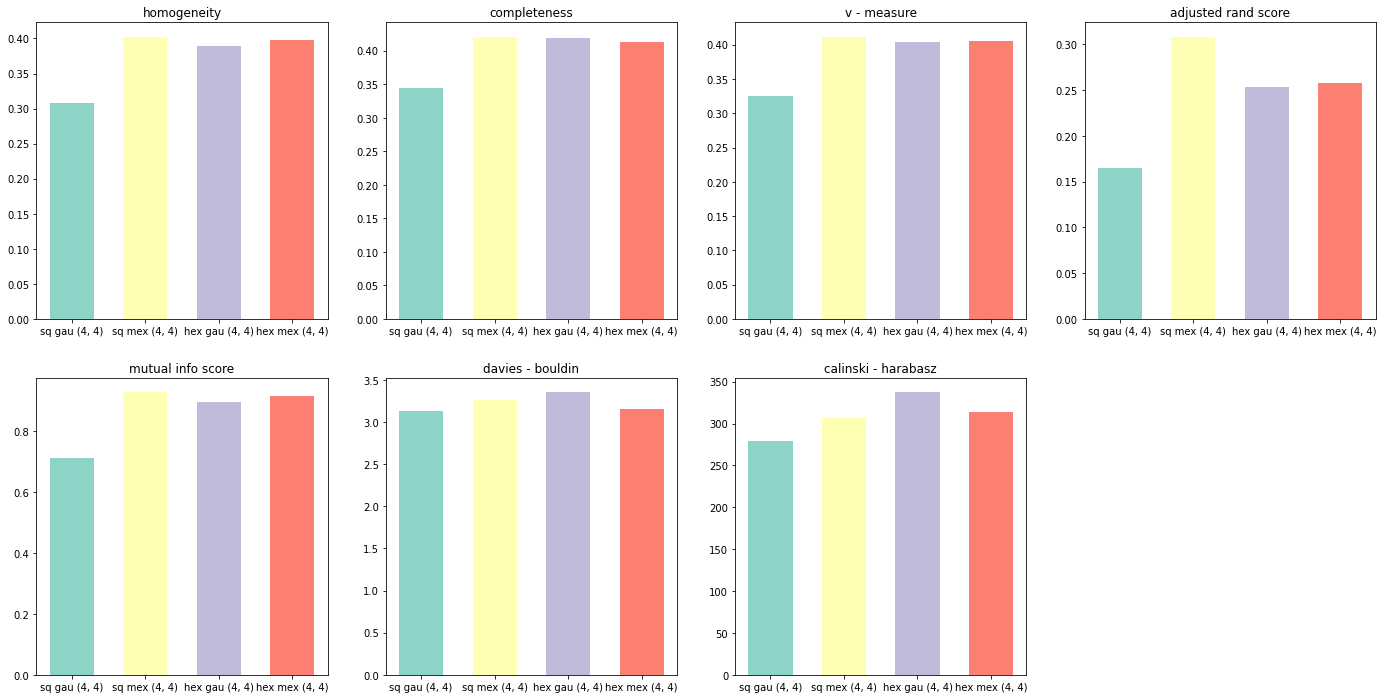

In [102]:
met = ['homogeneity', 'completeness', 'v - measure', 'adjusted rand score', 'mutual info score', 'davies - bouldin', 'calinski - harabasz']
plot_scores(df.loc[df['gridsize'] == grids[0], met])

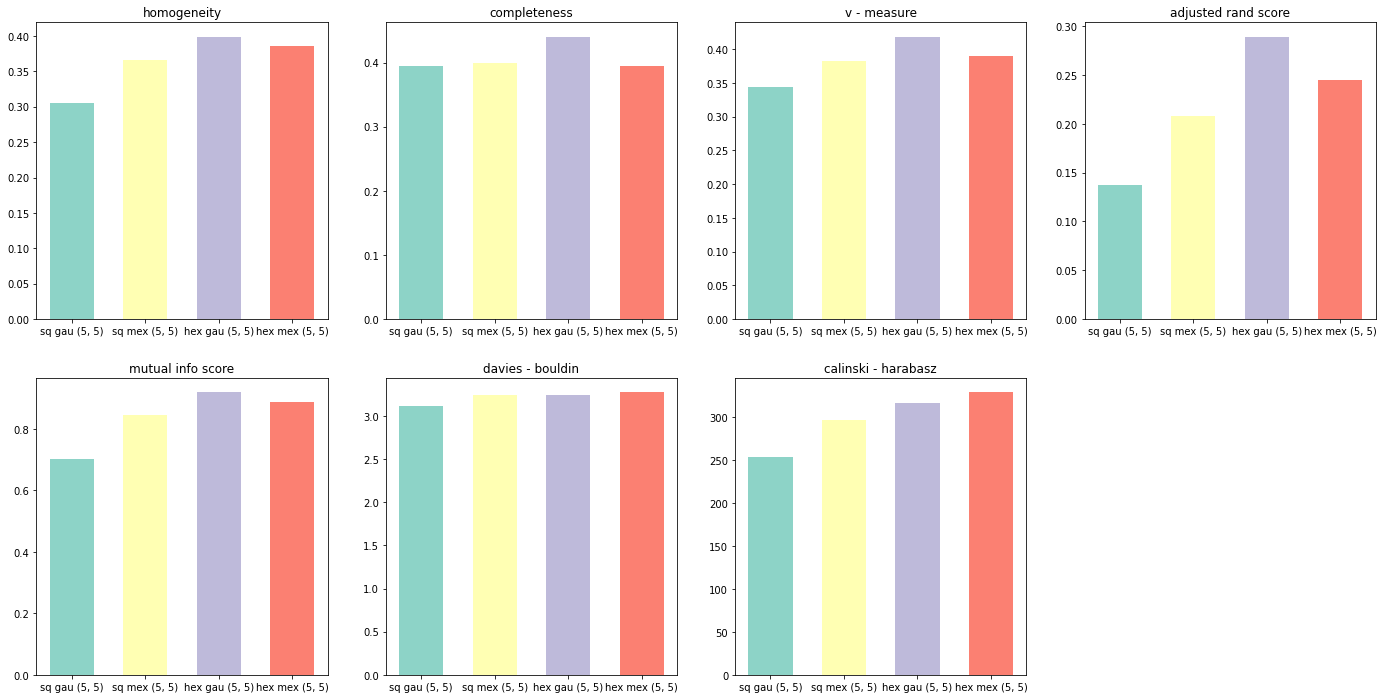

In [103]:
plot_scores(df.loc[df['gridsize'] == grids[1], met])

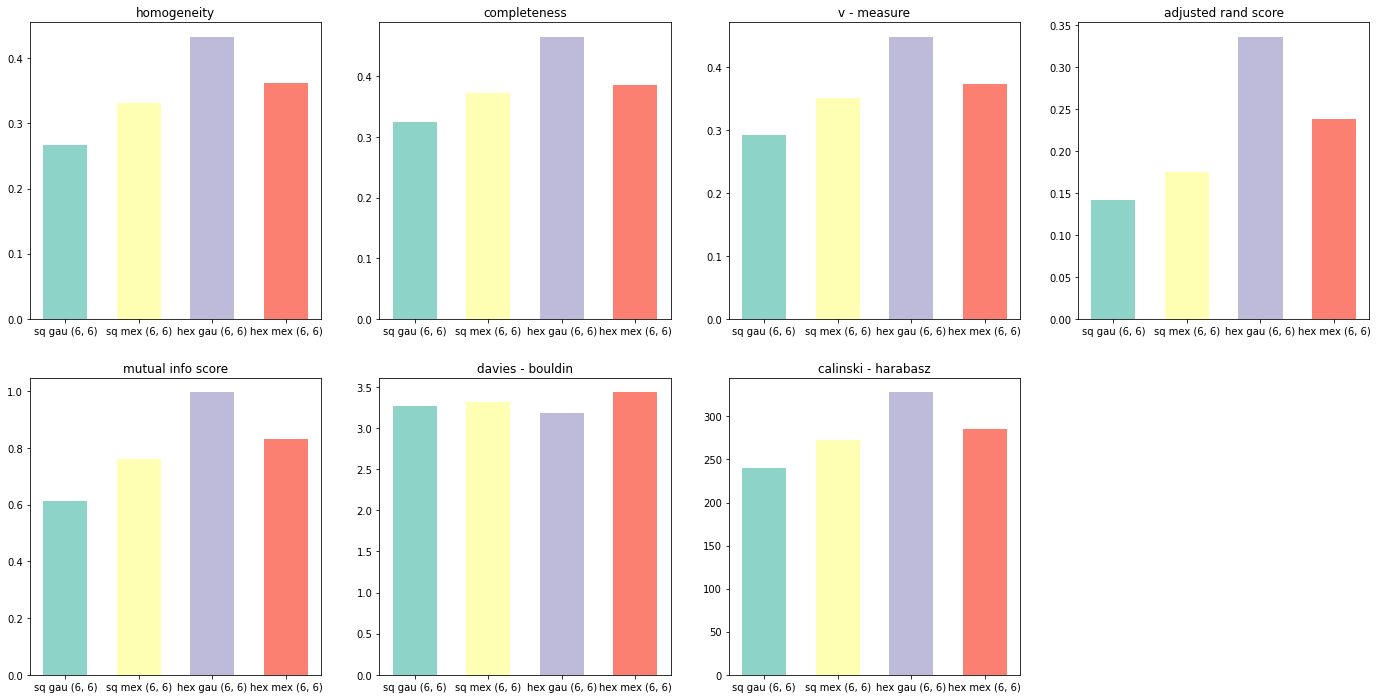

In [104]:
plot_scores(df.loc[df['gridsize'] == grids[2], met])

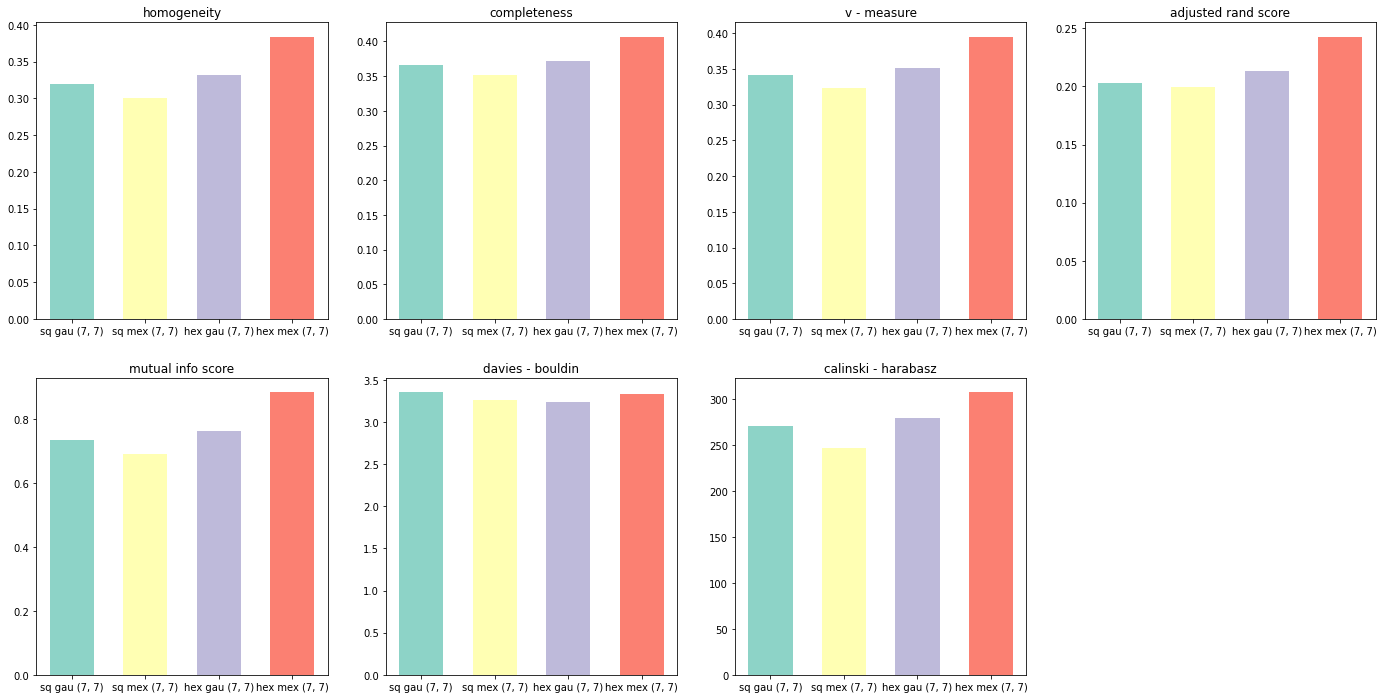

In [105]:
plot_scores(df.loc[df['gridsize'] == grids[3], met])

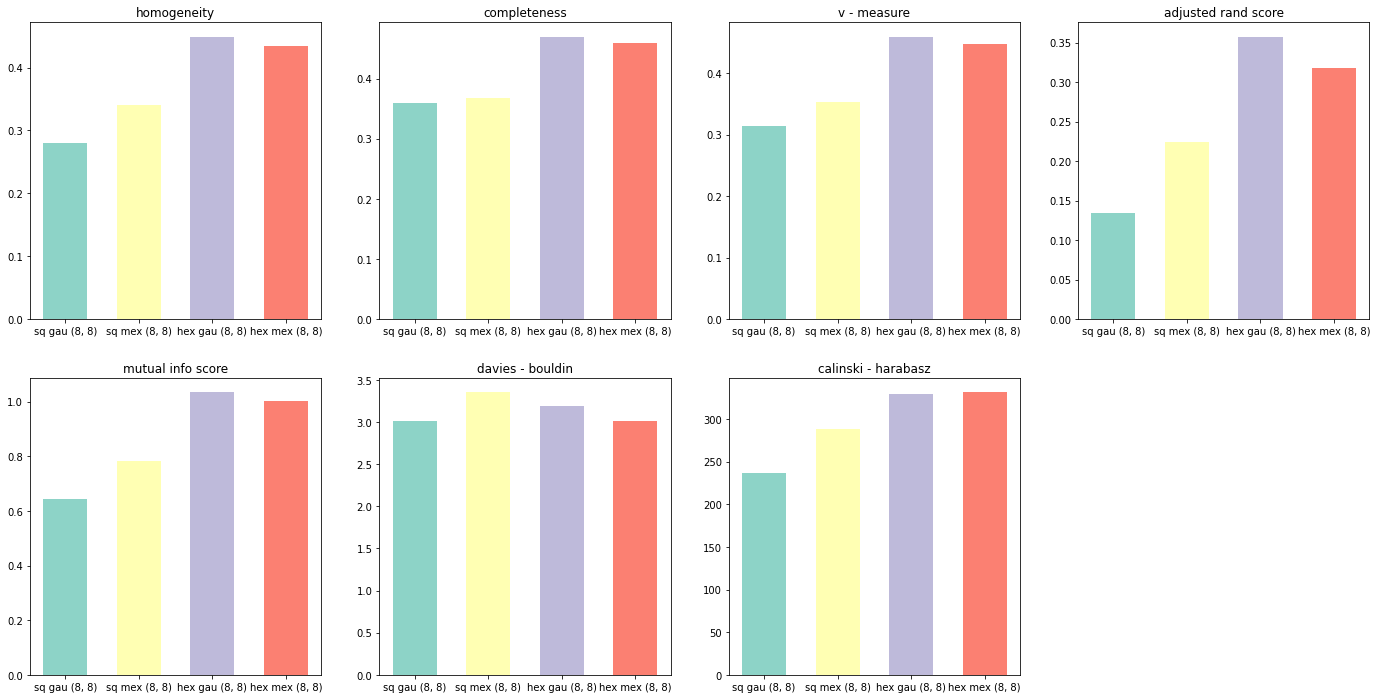

In [106]:
plot_scores(df.loc[df['gridsize'] == grids[4], met])

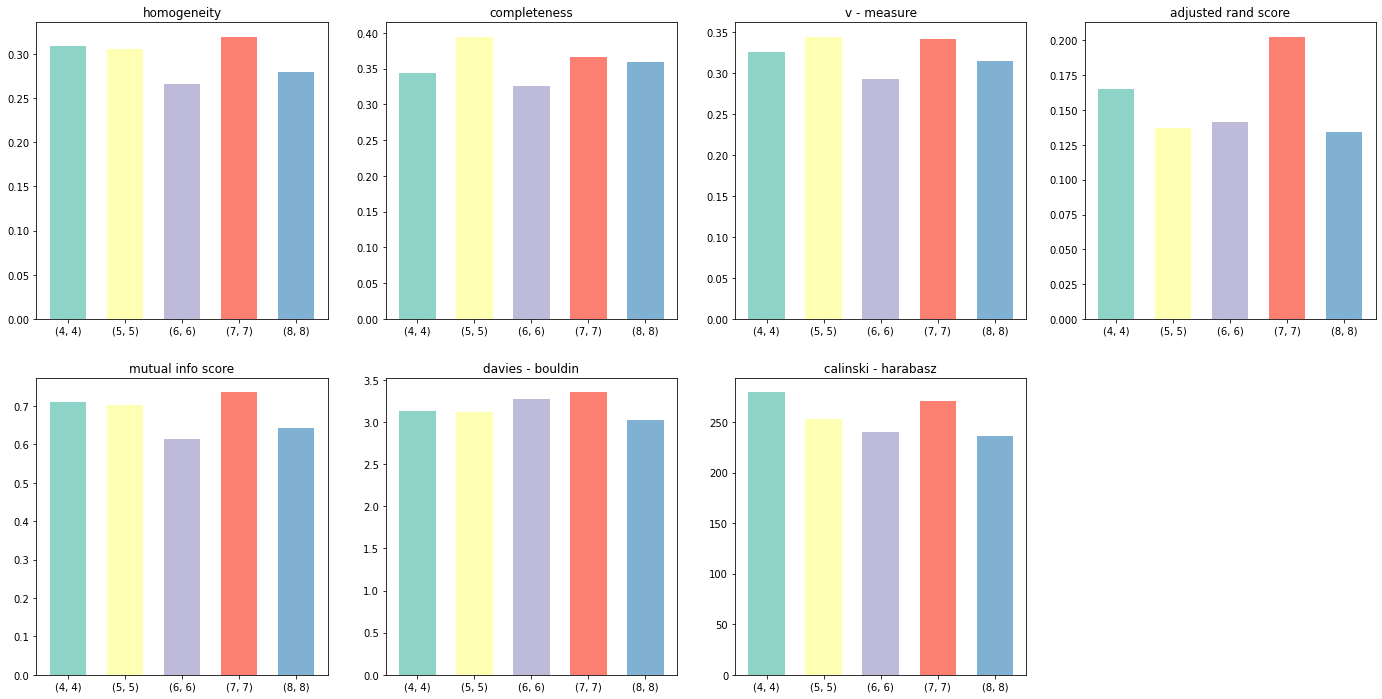

In [107]:
temp = df.loc[df['gridtype'] == 'sq gau', met]
temp.index = [str(grid) for grid in grids]
plot_scores(temp)

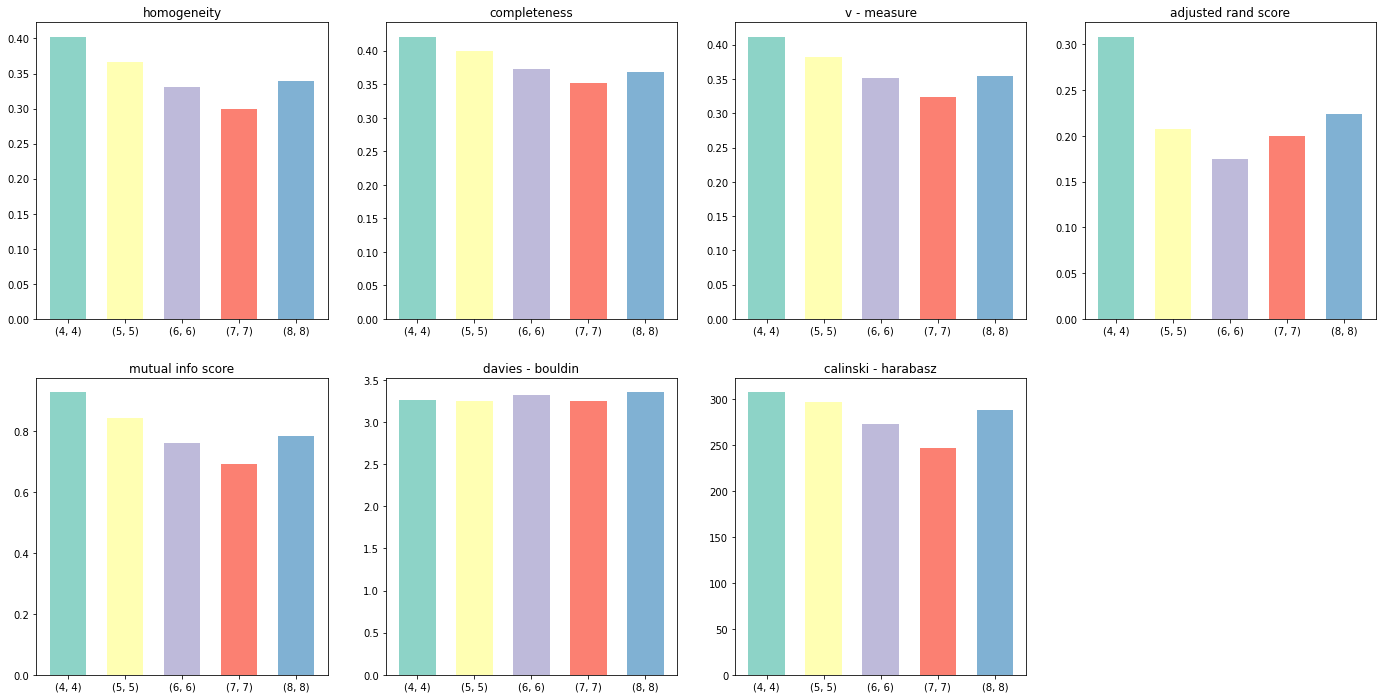

In [108]:
temp = df.loc[df['gridtype'] == 'sq mex', met]
temp.index = [str(grid) for grid in grids]
plot_scores(temp)

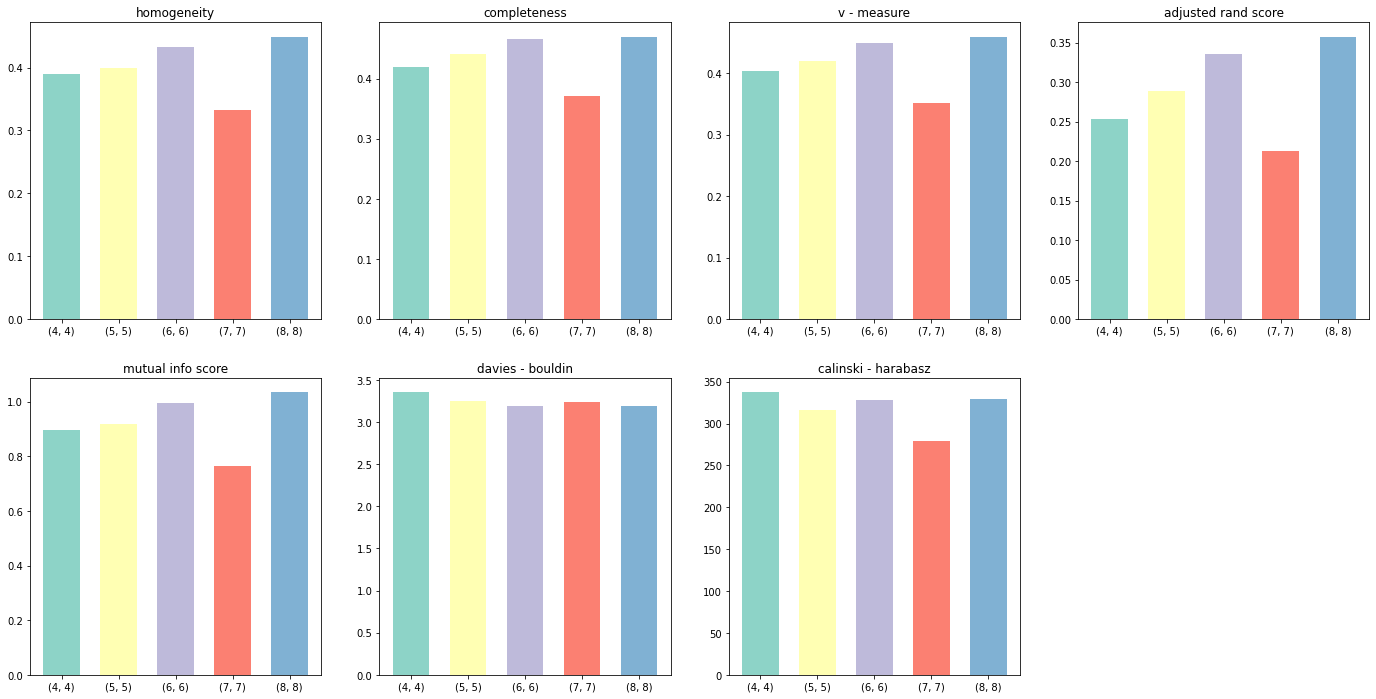

In [109]:
temp = df.loc[df['gridtype'] == 'hex gau', met]
temp.index = [str(grid) for grid in grids]
plot_scores(temp)

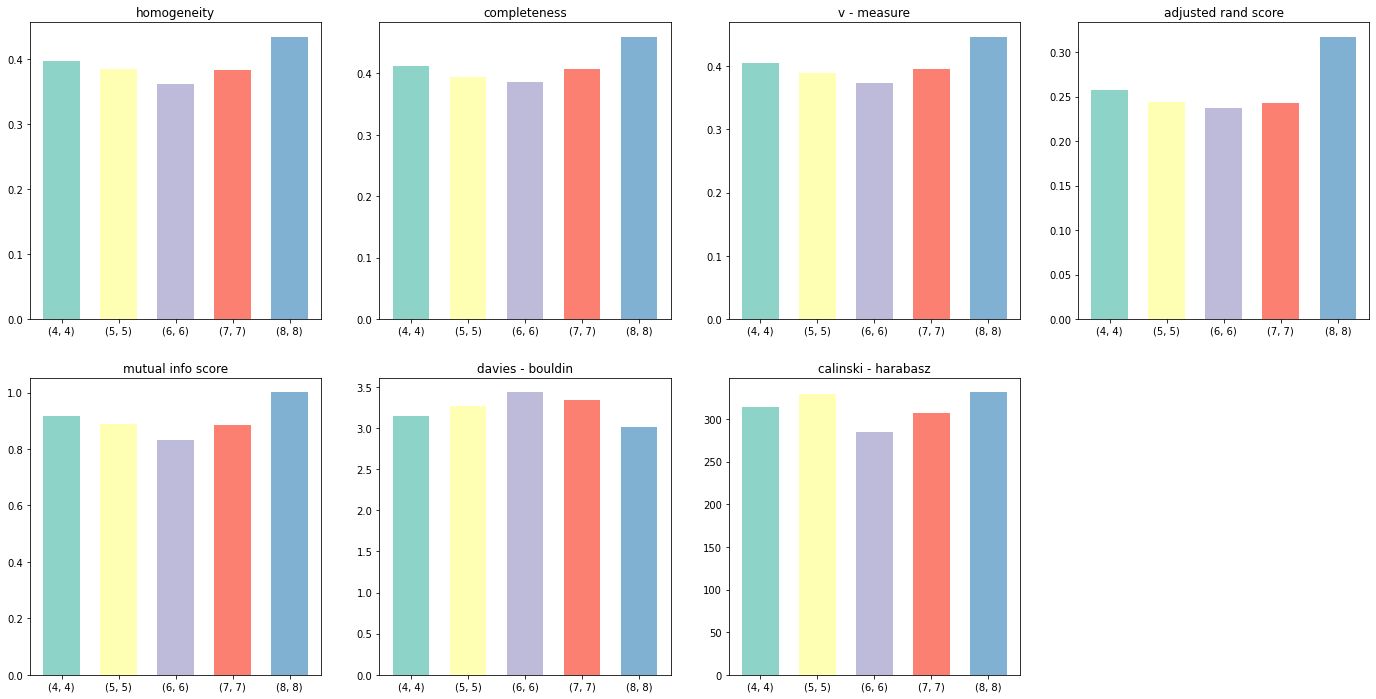

In [110]:
temp = df.loc[df['gridtype'] == 'hex mex', met]
temp.index = [str(grid) for grid in grids]
plot_scores(temp)

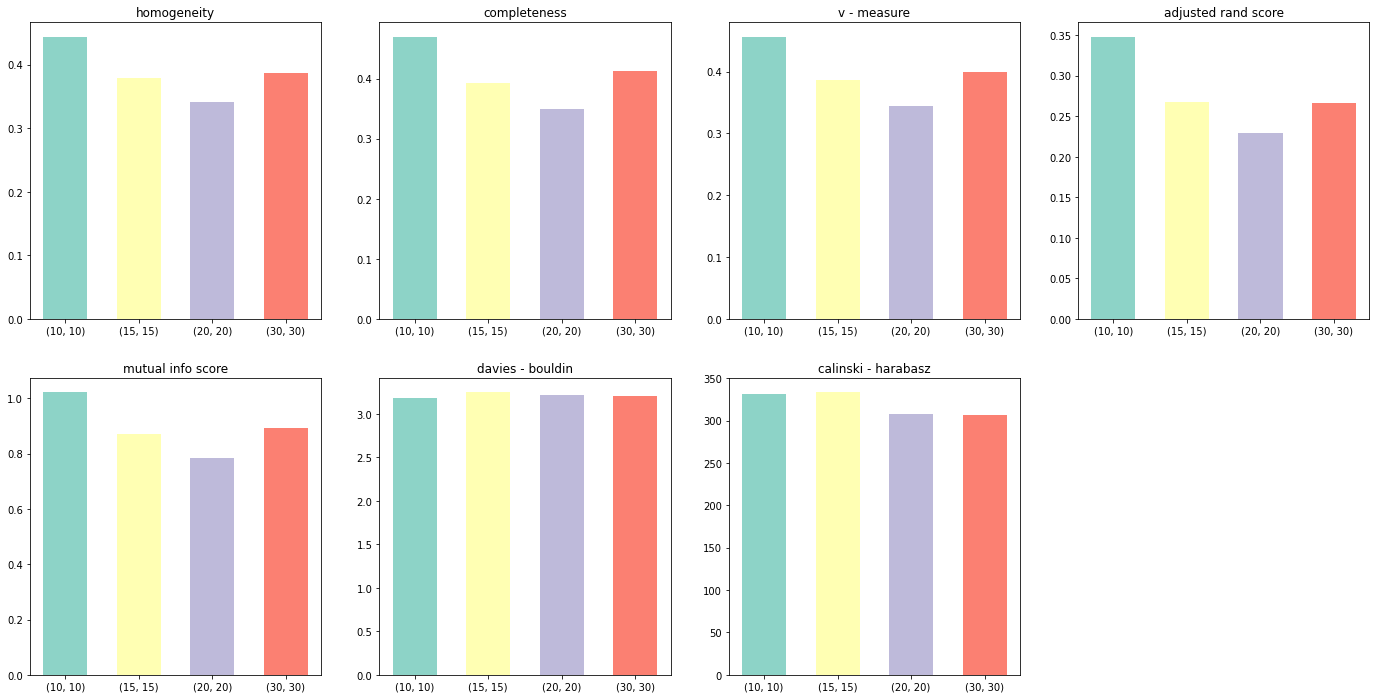

In [111]:
grids = [(x,x) for x in [10, 15, 20, 30]]
hex_eval, models_hex = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 32, width = 1/10, method = 'gauss', gridtype='hexagon')
hex_eval.index = [str(grid) for grid in grids]
plot_scores(hex_eval)

In [ ]:
models = [model1[0], model2[0], model3[0], model4[0]]
scores = []
score_fun_ext = {
            'homogeneity' : homogeneity_score,
            'completeness' : completeness_score,
            'v - measure' : v_measure_score,
            'adjusted rand score' : adjusted_rand_score,
            'mutual info score' : mutual_info_score
        }
score_fun_int = {
    'davies - bouldin' : davies_bouldin_score,
    'calinski - harabasz' : calinski_harabasz_score
}
for model in models:
    c = model.test(X_train)
    values = {}
    for name, fun in score_fun_ext.items():
        eval = fun(y_train.flatten(), c)
        values[name] = eval
    
    for name, fun in score_fun_int.items():
        eval = fun(X_train, c)
        values[name] = eval
    scores.append(values)
train = pd.DataFrame(scores)
train.index = ['sq gau', 'sq mex', 'hex gau', 'hex mex']
train

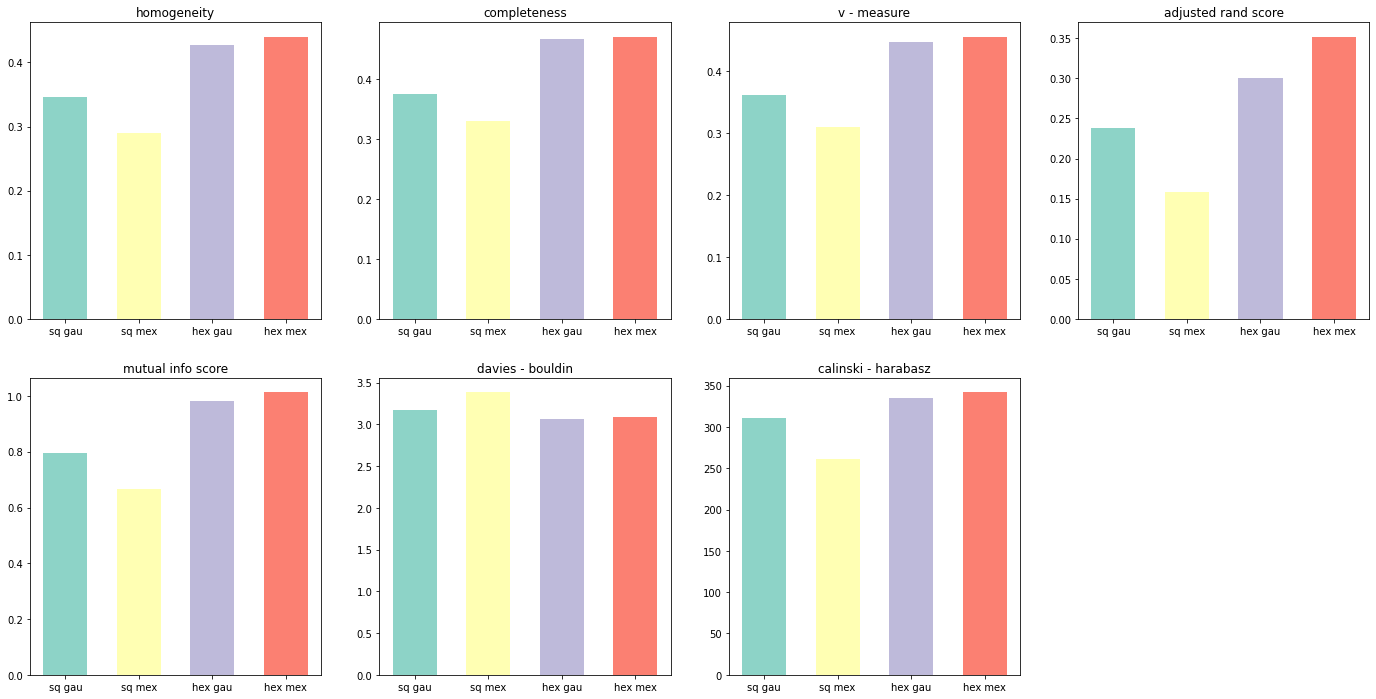

In [58]:
grids = (6,6)
eval1, model1 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/10)
eval2, model2 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/10, method = 'mexican')
eval3, model3 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/10, gridtype = 'hexagon')
eval4, model4 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/10, method = 'mexican', gridtype = 'hexagon')
df = pd.concat([eval1, eval2, eval3, eval4])
df.index = ['sq gau', 'sq mex', 'hex gau', 'hex mex']
plot_scores(df)

In [59]:
models = models = [model1[0], model2[0], model3[0], model4[0]]
scores = []
score_fun_ext = {
            'homogeneity' : homogeneity_score,
            'completeness' : completeness_score,
            'v - measure' : v_measure_score,
            'adjusted rand score' : adjusted_rand_score,
            'mutual info score' : mutual_info_score
        }
score_fun_int = {
    'davies - bouldin' : davies_bouldin_score,
    'calinski - harabasz' : calinski_harabasz_score
}
for model in models:
    c = model.test(X_train)
    values = {}
    for name, fun in score_fun_ext.items():
        eval = fun(y_train.flatten(), c)
        values[name] = eval
    
    for name, fun in score_fun_int.items():
        eval = fun(X_train, c)
        values[name] = eval
    scores.append(values)
train = pd.DataFrame(scores)
train.index = ['sq gau', 'sq mex', 'hex gau', 'hex mex']
train

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz
sq gau,0.339828,0.371062,0.354759,0.232096,0.781997,3.210707,1808.270658
sq mex,0.288309,0.330582,0.308002,0.158951,0.663445,3.462386,1497.598378
hex gau,0.412305,0.451177,0.430866,0.280390,0.948778,3.102039,1937.603123
hex mex,0.432876,0.462474,0.447186,0.346381,0.996116,3.099846,1993.535279


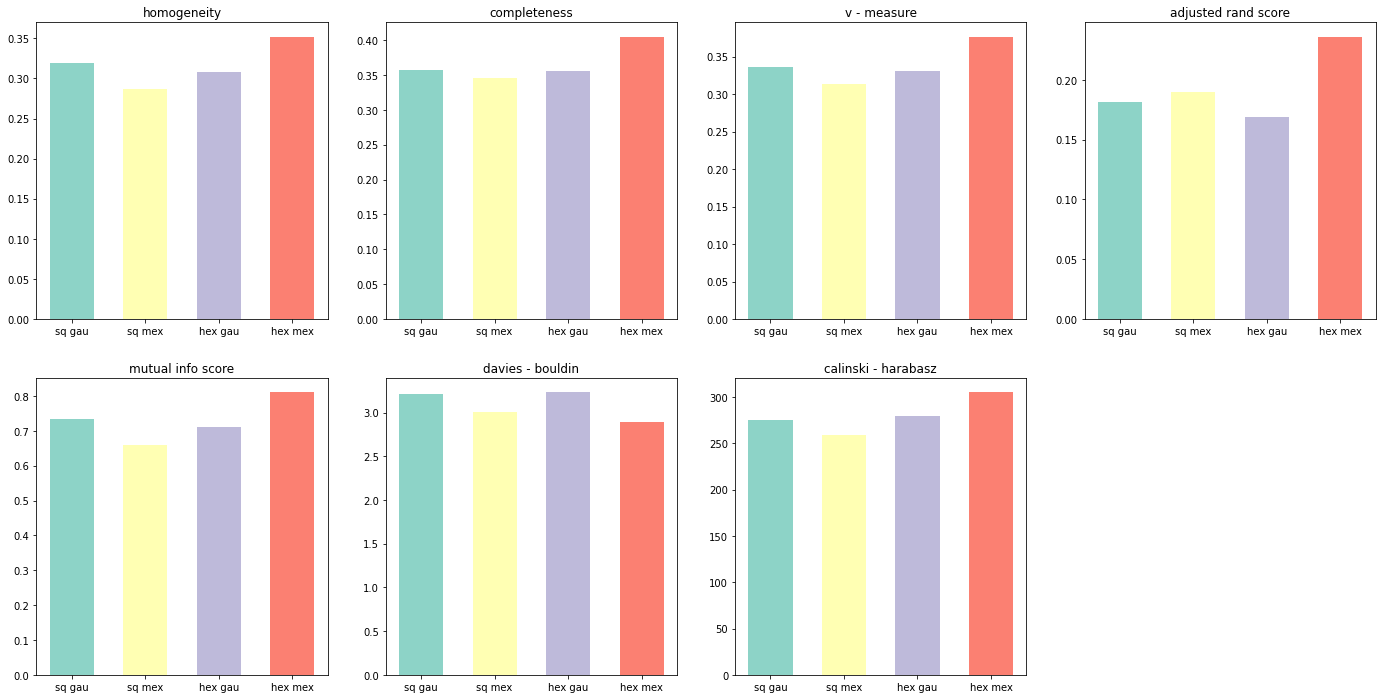

In [60]:
grids = (12,12)
eval1, model1 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/10)
eval2, model2 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/10, method = 'mexican')
eval3, model3 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/10, gridtype = 'hexagon')
eval4, model4 = compare_models(X_train, X_test, y_test.flatten(), grids, neurons = 10, iterations = 100, width = 1/10, method = 'mexican', gridtype = 'hexagon')
df = pd.concat([eval1, eval2, eval3, eval4])
df.index = ['sq gau', 'sq mex', 'hex gau', 'hex mex']
plot_scores(df)

In [61]:
models = models = [model1[0], model2[0], model3[0], model4[0]]
scores = []
score_fun_ext = {
            'homogeneity' : homogeneity_score,
            'completeness' : completeness_score,
            'v - measure' : v_measure_score,
            'adjusted rand score' : adjusted_rand_score,
            'mutual info score' : mutual_info_score
        }
score_fun_int = {
    'davies - bouldin' : davies_bouldin_score,
    'calinski - harabasz' : calinski_harabasz_score
}
for model in models:
    c = model.test(X_train)
    values = {}
    for name, fun in score_fun_ext.items():
        eval = fun(y_train.flatten(), c)
        values[name] = eval
    
    for name, fun in score_fun_int.items():
        eval = fun(X_train, c)
        values[name] = eval
    scores.append(values)
train = pd.DataFrame(scores)
train.index = ['sq gau', 'sq mex', 'hex gau', 'hex mex']
train

,homogeneity,completeness,v - measure,adjusted rand score,mutual info score,davies - bouldin,calinski - harabasz
sq gau,0.299315,0.340901,0.318757,0.161988,0.688772,3.308564,1555.893304
sq mex,0.280986,0.336096,0.306080,0.181750,0.646594,3.104747,1513.301438
hex gau,0.301585,0.348611,0.323397,0.165211,0.693995,3.286803,1610.978505
hex mex,0.339664,0.391744,0.363850,0.222616,0.781622,2.912525,1763.242812
